# Week 8 Jupyter Notebook - K-Nearest Neighbors
Each week, you will apply the concepts of that week to your Integrated Capstone Project’s dataset. In preparation for Milestone Two, create a Jupyter Notebook (similar to in Module B, Semester Two) that illustrates these lessons. There are no specific questions to answer in your Jupyter Notebook files in this course; your general goal is to analyze your data using the methods you have learned about in this course and in this program and draw interesting conclusions. 

For this week, include ideas such as **K-Nearest Neighbors** and **distance metrics**. Complete your Jupyter Notebook homework by 11:59pm ET on Sunday. 

In Week 12, you will compile your findings from your Jupyter Notebook homework into your Milestone Two assignment for grading. For full instructions and the rubric for Milestone Two, refer to the following link. 

K-nearest neighbors (with different metrics) (Week 8)

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, LeaveOneOut, cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import RobustScaler
from sklearn.impute import KNNImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                           roc_curve, precision_recall_curve, average_precision_score,
                           make_scorer, accuracy_score)
import warnings
warnings.filterwarnings('ignore')

## Dataset 1 Initial Fit

In [2]:
def load_collision_data():
    """Load the collision feature datasets"""
    print("\n Loading collision feature datasets...")
    
    injury_df = pd.read_csv('scripts/punt_analytics/injury_collision_features.csv')
    normal_df = pd.read_csv('scripts/punt_analytics/normal_collision_features.csv')
    
    print(f" Loaded {len(injury_df)} injury collisions")
    print(f" Loaded {len(normal_df)} normal collisions")
    
    combined_df = pd.concat([injury_df, normal_df], ignore_index=True)
    print(f" Combined dataset: {len(combined_df)} total collisions")
    print(f" Injury rate: {combined_df['is_injury'].mean():.1%}")
    
    return combined_df, injury_df, normal_df

combined_df, injury_df, normal_df = load_collision_data()


 Loading collision feature datasets...
 Loaded 28 injury collisions
 Loaded 280 normal collisions
 Combined dataset: 308 total collisions
 Injury rate: 9.1%


In [3]:
def preprocess_small_dataset(df, target_col='is_injury', remove_outliers=False):
    """preprocessing for Concussion datasets"""
    print("\n Preprocessing for Concussion dataset...")
    
    # Identify feature columns
    exclude_cols = [
        'season_year', 'gamekey', 'playid', 'injured_player', 'partner_player',
        'impact_type', 'player_activity', 'partner_activity', 'friendly_fire', 'is_injury'
    ]
    
    feature_cols = [col for col in df.columns if col not in exclude_cols]
    print(f" Identified {len(feature_cols)} potential features")
    
    X = df[feature_cols].copy()
    y = df[target_col].copy()
    
    # Remove features with >50% missing (more conservative for small datasets)
    missing_pcts = X.isnull().mean()
    high_missing = missing_pcts[missing_pcts > 0.5].index.tolist()
    if high_missing:
        print(f"🗑️ Removing {len(high_missing)} features with >50% missing data")
        X = X.drop(columns=high_missing)
    
    print(f" Features after missing data filter: {X.shape[1]}")
    
    # Simple imputation for small datasets
    print(" Handling missing data with median imputation...")
    for col in X.columns:
        if X[col].isnull().any():
            X[col] = X[col].fillna(X[col].median())
    
    # Only create most important engineered features
    print(" Creating key engineered features...")
    
    # Collision intensity (most important from previous analysis)
    if 'min_distance' in X.columns and 'max_relative_speed' in X.columns:
        X['collision_intensity'] = (1 / (X['min_distance'] + 0.1)) * (X['max_relative_speed'] / X['max_relative_speed'].max())
    
    # Speed ratio
    if 'p1_max_speed' in X.columns and 'p2_max_speed' in X.columns:
        X['speed_ratio'] = X['p1_max_speed'] / (X['p2_max_speed'] + 1e-6)
    
    # Conservative outlier removal (only extreme outliers)
    if remove_outliers:
        print(" Conservative outlier removal...")
        outlier_mask = np.zeros(len(X), dtype=bool)
        
        for col in X.select_dtypes(include=[np.number]).columns:
            Q1 = X[col].quantile(0.05)  # More conservative percentiles
            Q3 = X[col].quantile(0.95)
            IQR = Q3 - Q1
            lower_bound = Q1 - 3 * IQR  # 3 IQR instead of 1.5
            upper_bound = Q3 + 3 * IQR
            
            col_outliers = (X[col] < lower_bound) | (X[col] > upper_bound)
            outlier_mask |= col_outliers
        
        # Only remove if we don't lose too many samples
        outlier_count = outlier_mask.sum()
        if outlier_count < len(X) * 0.3:  # Don't remove more than 30%
            X = X[~outlier_mask]
            y = y[~outlier_mask]
            print(f"🗑️ Removed {outlier_count} extreme outliers")
        else:
            print(f"⚠️ Skipping outlier removal (would remove {outlier_count} samples)")
    
    print(f" Final dataset: {len(X)} samples, {X.shape[1]} features")
    print(f" Class distribution: {y.value_counts().to_dict()}")
    
    return X, y

# Preprocess with conservative settings
X, y = preprocess_small_dataset(combined_df, remove_outliers=False)  # Skip outlier removal


 Preprocessing for Concussion dataset...
 Identified 23 potential features
 Features after missing data filter: 23
 Handling missing data with median imputation...
 Creating key engineered features...
 Final dataset: 308 samples, 25 features
 Class distribution: {0: 280, 1: 28}


In [4]:
def select_features_small_dataset(X, y, k=8):
    """Feature selection optimized for small datasets"""
    print(f"\n STEP 3: Selecting top {k} features for small dataset...")
    
    # Use fewer features for small datasets to avoid overfitting
    k = min(k, X.shape[1], len(y) // 3)  # Rule: max features = samples/3
    
    if X.shape[1] > k:
        selector = SelectKBest(score_func=f_classif, k=k)
        X_selected = selector.fit_transform(X, y)
        
        selected_features = X.columns[selector.get_support()].tolist()
        feature_scores = selector.scores_[selector.get_support()]
        
        print(" Selected features:")
        for feature, score in zip(selected_features, feature_scores):
            print(f"   {feature:<30} Score: {score:.2f}")
        
        X_selected = pd.DataFrame(X_selected, columns=selected_features, index=X.index)
    else:
        X_selected = X
        selected_features = X.columns.tolist()
    
    # Scale features
    print(" Scaling features...")
    scaler = RobustScaler()
    X_scaled = pd.DataFrame(
        scaler.fit_transform(X_selected),
        columns=selected_features,
        index=X_selected.index
    )
    
    return X_scaled, selected_features, scaler

X_scaled, feature_names, scaler = select_features_small_dataset(X, y, k=8)


 STEP 3: Selecting top 8 features for small dataset...
 Selected features:
   min_distance                   Score: 33.89
   time_to_closest_approach       Score: 30.79
   max_relative_speed             Score: 78.79
   relative_speed_at_closest      Score: 6.10
   p2_max_speed                   Score: 5.46
   p1_acceleration_before_collision Score: 12.16
   play_duration                  Score: 49.94
   collision_intensity            Score: 348.41
 Scaling features...


In [5]:
from sklearn.neighbors import KNeighborsClassifier

def evaluate_models_small_dataset(X, y, feature_names):
    """Model evaluation optimized for small datasets using cross-validation"""
    print("\n STEP 4: Model evaluation with cross-validation...")
    
    # Simpler models for small datasets
    models = {
        'NearestNeighbors': KNeighborsClassifier(
            n_neighbors=3, weights='uniform', algorithm='auto'
        )
    }
    
    print(f" Dataset: {len(X)} samples, {X.shape[1]} features")
    print(f" Class distribution: {y.value_counts().to_dict()}")
    
    # Use Leave-One-Out CV for very small datasets
    if len(X) < 30:
        cv = LeaveOneOut()
        cv_name = "Leave-One-Out"
    else:
        cv = StratifiedKFold(n_splits=min(5, len(y[y==1])), shuffle=True, random_state=42)
        cv_name = "Stratified K-Fold"
    
    print(f" Using {cv_name} cross-validation...")
    
    results = {}
    
    # Custom scoring for small datasets
    def balanced_accuracy_score(y_true, y_pred):
        from sklearn.metrics import balanced_accuracy_score as bas
        return bas(y_true, y_pred)
    
    for name, model in models.items():
        print(f"\n Evaluating {name}...")
        
        try:
            # Cross-validation scores
            cv_scores_acc = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
            cv_scores_bal = cross_val_score(model, X, y, cv=cv, 
                                          scoring=make_scorer(balanced_accuracy_score))
            
            # Fit model on full dataset for analysis
            model.fit(X, y)
            y_pred = model.predict(X)
            y_pred_proba = model.predict_proba(X)[:, 1] if hasattr(model, 'predict_proba') else None
            
            results[name] = {
                'model': model,
                'cv_accuracy': cv_scores_acc,
                'cv_balanced_accuracy': cv_scores_bal,
                'mean_accuracy': cv_scores_acc.mean(),
                'mean_balanced_accuracy': cv_scores_bal.mean(),
                'y_pred': y_pred,
                'y_pred_proba': y_pred_proba
            }
            
            print(f"   Accuracy: {cv_scores_acc.mean():.3f} ± {cv_scores_acc.std():.3f}")
            print(f"   Balanced Accuracy: {cv_scores_bal.mean():.3f} ± {cv_scores_bal.std():.3f}")
            
            # Classification report
            report = classification_report(y, y_pred, output_dict=True, zero_division=0)
            if '1' in report:
                print(f"   Injury Detection - Precision: {report['1']['precision']:.3f}, Recall: {report['1']['recall']:.3f}")
            
        except Exception as e:
            print(f"    Error evaluating {name}: {str(e)}")
            results[name] = {'error': str(e)}
    
    # Find best model
    valid_results = {k: v for k, v in results.items() if 'error' not in v}
    if valid_results:
        best_model_name = max(valid_results.keys(), key=lambda x: valid_results[x]['mean_balanced_accuracy'])
        best_model = valid_results[best_model_name]['model']
        print(f"\n Best model: {best_model_name}")
    else:
        best_model_name = list(results.keys())[0]
        best_model = None
        print("\n No models evaluated successfully")
    
    return results, best_model, best_model_name

results, best_model, best_model_name = evaluate_models_small_dataset(X_scaled, y, feature_names)


 STEP 4: Model evaluation with cross-validation...
 Dataset: 308 samples, 8 features
 Class distribution: {0: 280, 1: 28}
 Using Stratified K-Fold cross-validation...

 Evaluating NearestNeighbors...
   Accuracy: 0.955 ± 0.024
   Balanced Accuracy: 0.849 ± 0.114
   Injury Detection - Precision: 0.893, Recall: 0.893

 Best model: NearestNeighbors



 STEP 5: Analysis for small dataset...
 Feature importance not available
Creating visualizations...


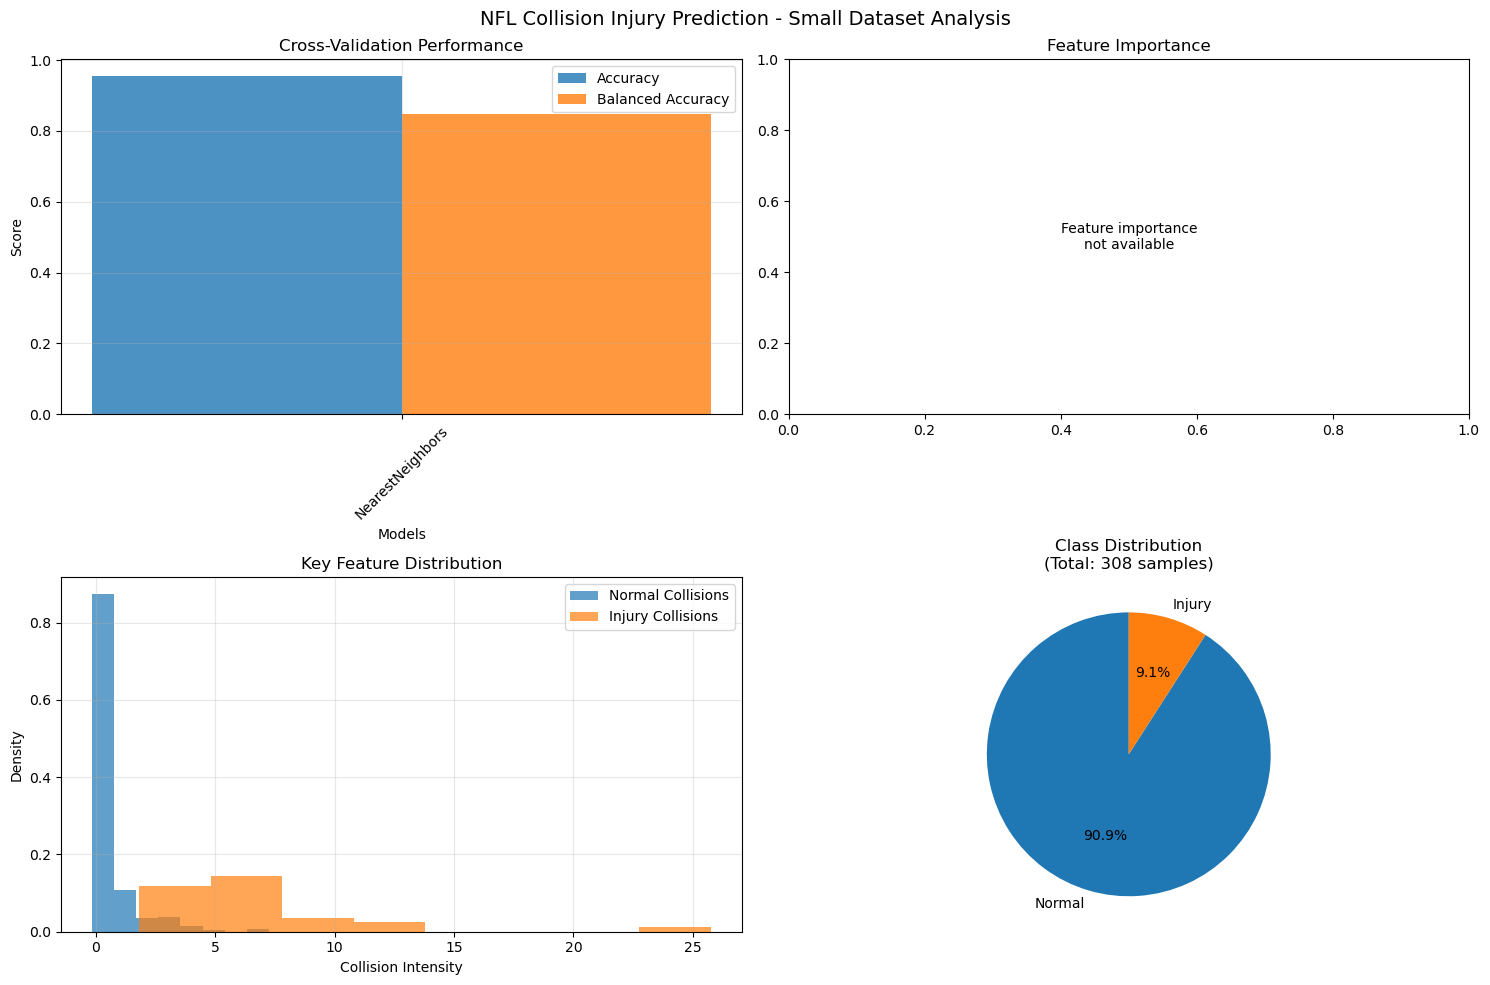

In [7]:
def analyze_small_dataset_results(results, X, y, feature_names, best_model, best_model_name):
    """Analysis and visualization for small datasets"""
    print("\n STEP 5: Analysis for small dataset...")
    
    # Feature importance analysis
    if best_model is not None and hasattr(best_model, 'coef_'):
        print(" Analyzing feature importance...")
        importances = np.abs(best_model.coef_[0])
        feature_importance = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values('importance', ascending=False)
        
        print(" Top features by importance:")
        for _, row in feature_importance.iterrows():
            print(f"   {row['feature']:<30} {row['importance']:.4f}")
    else:
        feature_importance = None
        print(" Feature importance not available")
    
    # Visualizations for small datasets
    print("Creating visualizations...")
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('NFL Collision Injury Prediction - Small Dataset Analysis', fontsize=14)
    
    # 1. Cross-validation scores comparison
    ax = axes[0, 0]
    valid_results = {k: v for k, v in results.items() if 'error' not in v}
    
    if valid_results:
        model_names = list(valid_results.keys())
        accuracies = [valid_results[name]['mean_accuracy'] for name in model_names]
        balanced_accuracies = [valid_results[name]['mean_balanced_accuracy'] for name in model_names]
        
        x = np.arange(len(model_names))
        width = 0.35
        
        ax.bar(x - width/2, accuracies, width, label='Accuracy', alpha=0.8)
        ax.bar(x + width/2, balanced_accuracies, width, label='Balanced Accuracy', alpha=0.8)
        
        ax.set_xlabel('Models')
        ax.set_ylabel('Score')
        ax.set_title('Cross-Validation Performance')
        ax.set_xticks(x)
        ax.set_xticklabels(model_names, rotation=45)
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # 2. Feature importance
    ax = axes[0, 1]
    if feature_importance is not None:
        bars = ax.barh(range(len(feature_importance)), feature_importance['importance'])
        ax.set_yticks(range(len(feature_importance)))
        ax.set_yticklabels(feature_importance['feature'])
        ax.set_xlabel('Importance')
        ax.set_title('Feature Importance')
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, 'Feature importance\nnot available', 
               ha='center', va='center', transform=ax.transAxes)
        ax.set_title('Feature Importance')
    
    # 3. Data distribution
    ax = axes[1, 0]
    if 'collision_intensity' in X.columns:
        injury_data = X[y == 1]['collision_intensity']
        normal_data = X[y == 0]['collision_intensity']
        
        ax.hist(normal_data, bins=8, alpha=0.7, label='Normal Collisions', density=True)
        ax.hist(injury_data, bins=8, alpha=0.7, label='Injury Collisions', density=True)
        ax.set_xlabel('Collision Intensity')
        ax.set_ylabel('Density')
        ax.set_title('Key Feature Distribution')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # 4. Sample size and class balance
    ax = axes[1, 1]
    class_counts = y.value_counts()
    ax.pie(class_counts.values, labels=['Normal', 'Injury'], autopct='%1.1f%%', startangle=90)
    ax.set_title(f'Class Distribution\n(Total: {len(y)} samples)')
    
    plt.tight_layout()
    plt.show()
    
    return feature_importance

feature_importance = analyze_small_dataset_results(results, X_scaled, y, feature_names, best_model, best_model_name)

In [8]:
def generate_small_dataset_summary(results, best_model_name, X, y, feature_names):
    """Generate summary appropriate for small datasets"""
    print(" Collision Analysis Summary ")
    
    print(f" Dataset Characteristics:")
    print(f" - Total samples: {len(y)}")
    print(f" - Injury samples: {sum(y)} ({(sum(y)/len(y)):.1%})")
    print(f" - Normal samples: {len(y) - sum(y)} ({((len(y) - sum(y))/len(y)):.1%})")
    print(f" - Features analyzed: {len(feature_names)}")
    
    valid_results = {k: v for k, v in results.items() if 'error' not in v}
    
    if valid_results and best_model_name in valid_results:
        best_result = valid_results[best_model_name]
        
        print(f"\n Best Model: {best_model_name}")
        print(f"   - Cross-validation Accuracy: {best_result['mean_accuracy']:.3f}")
        print(f"   - Balanced Accuracy: {best_result['mean_balanced_accuracy']:.3f}")
        print(f"   - Features used: {', '.join(feature_names)}")
    
    return {
        'sample_size': len(y),
        'injury_rate': sum(y)/len(y),
        'best_model': best_model_name,
        'best_accuracy': valid_results[best_model_name]['mean_balanced_accuracy'] if valid_results and best_model_name in valid_results else None
    }

summary = generate_small_dataset_summary(results, best_model_name, X_scaled, y, feature_names)

# Store results
small_dataset_results = {
    'X': X_scaled,
    'y': y,
    'results': results,
    'best_model': best_model,
    'feature_names': feature_names,
    'feature_importance': feature_importance,
    'summary': summary
}


 SUMMARY - SMALL DATASET COLLISION ANALYSIS
 Dataset Characteristics:
   • Total samples: 308
   • Injury samples: 28 (9.1%)
   • Normal samples: 280 (90.9%)
   • Features analyzed: 8

 Best Model: NearestNeighbors
   • Cross-validation Accuracy: 0.955
   • Balanced Accuracy: 0.849
   • Features used: min_distance, time_to_closest_approach, max_relative_speed, relative_speed_at_closest, p2_max_speed, p1_acceleration_before_collision, play_duration, collision_intensity

 Analysis Complete!
Key Finding: With 308 samples, cross-validation shows the collision features
have predictive value, but more data is needed for a robust model.

 Results stored in 'small_dataset_results' for further analysis!


## DataSet 1 Distance Metrics


 KNN Distance Metrics Analysis...
 Testing 4 distance metrics with K values: [1, 3, 5, 7, 9, 11, 15]

 Evaluating Euclidean (L2)...
   K=1: 0.876 ± 0.060
   K=3: 0.849 ± 0.114
   K=5: 0.869 ± 0.111
   K=7: 0.866 ± 0.102
   K=9: 0.829 ± 0.130
   K=11: 0.831 ± 0.095
   K=15: 0.776 ± 0.113

 Evaluating Manhattan (L1)...
   K=1: 0.809 ± 0.074
   K=3: 0.853 ± 0.111
   K=5: 0.820 ± 0.116
   K=7: 0.853 ± 0.111
   K=9: 0.855 ± 0.113
   K=11: 0.835 ± 0.093
   K=15: 0.815 ± 0.108

 Evaluating Chebyshev (L_inf)...
   K=1: 0.857 ± 0.084
   K=3: 0.869 ± 0.111
   K=5: 0.849 ± 0.093
   K=7: 0.831 ± 0.095
   K=9: 0.831 ± 0.132
   K=11: 0.814 ± 0.115
   K=15: 0.774 ± 0.114

 Evaluating Minkowski (p=3)...
   K=1: 0.859 ± 0.080
   K=3: 0.899 ± 0.110
   K=5: 0.829 ± 0.092
   K=7: 0.848 ± 0.085
   K=9: 0.834 ± 0.135
   K=11: 0.814 ± 0.115
   K=15: 0.793 ± 0.100

 Creating distance metrics comparison plots...


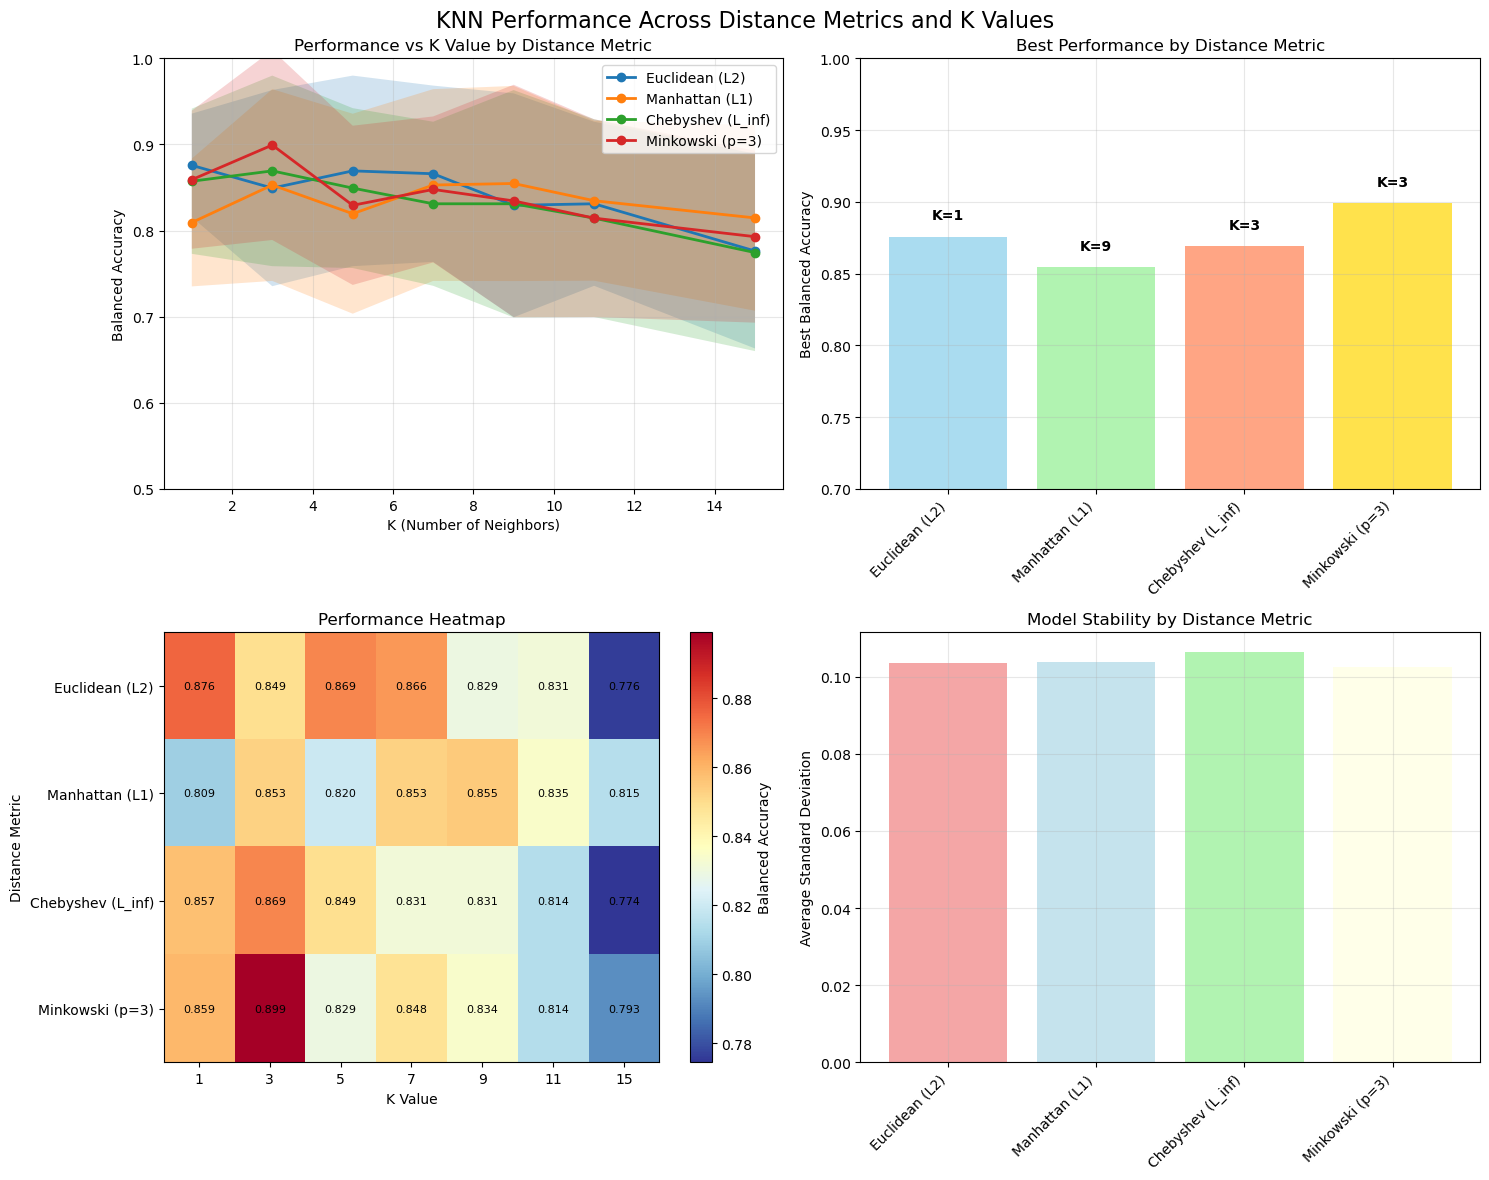


 STEP 7: Residual Analysis for Best KNN Model...
 Best model: Minkowski (p=3) with K=3
 Best cross-validation score: 0.899


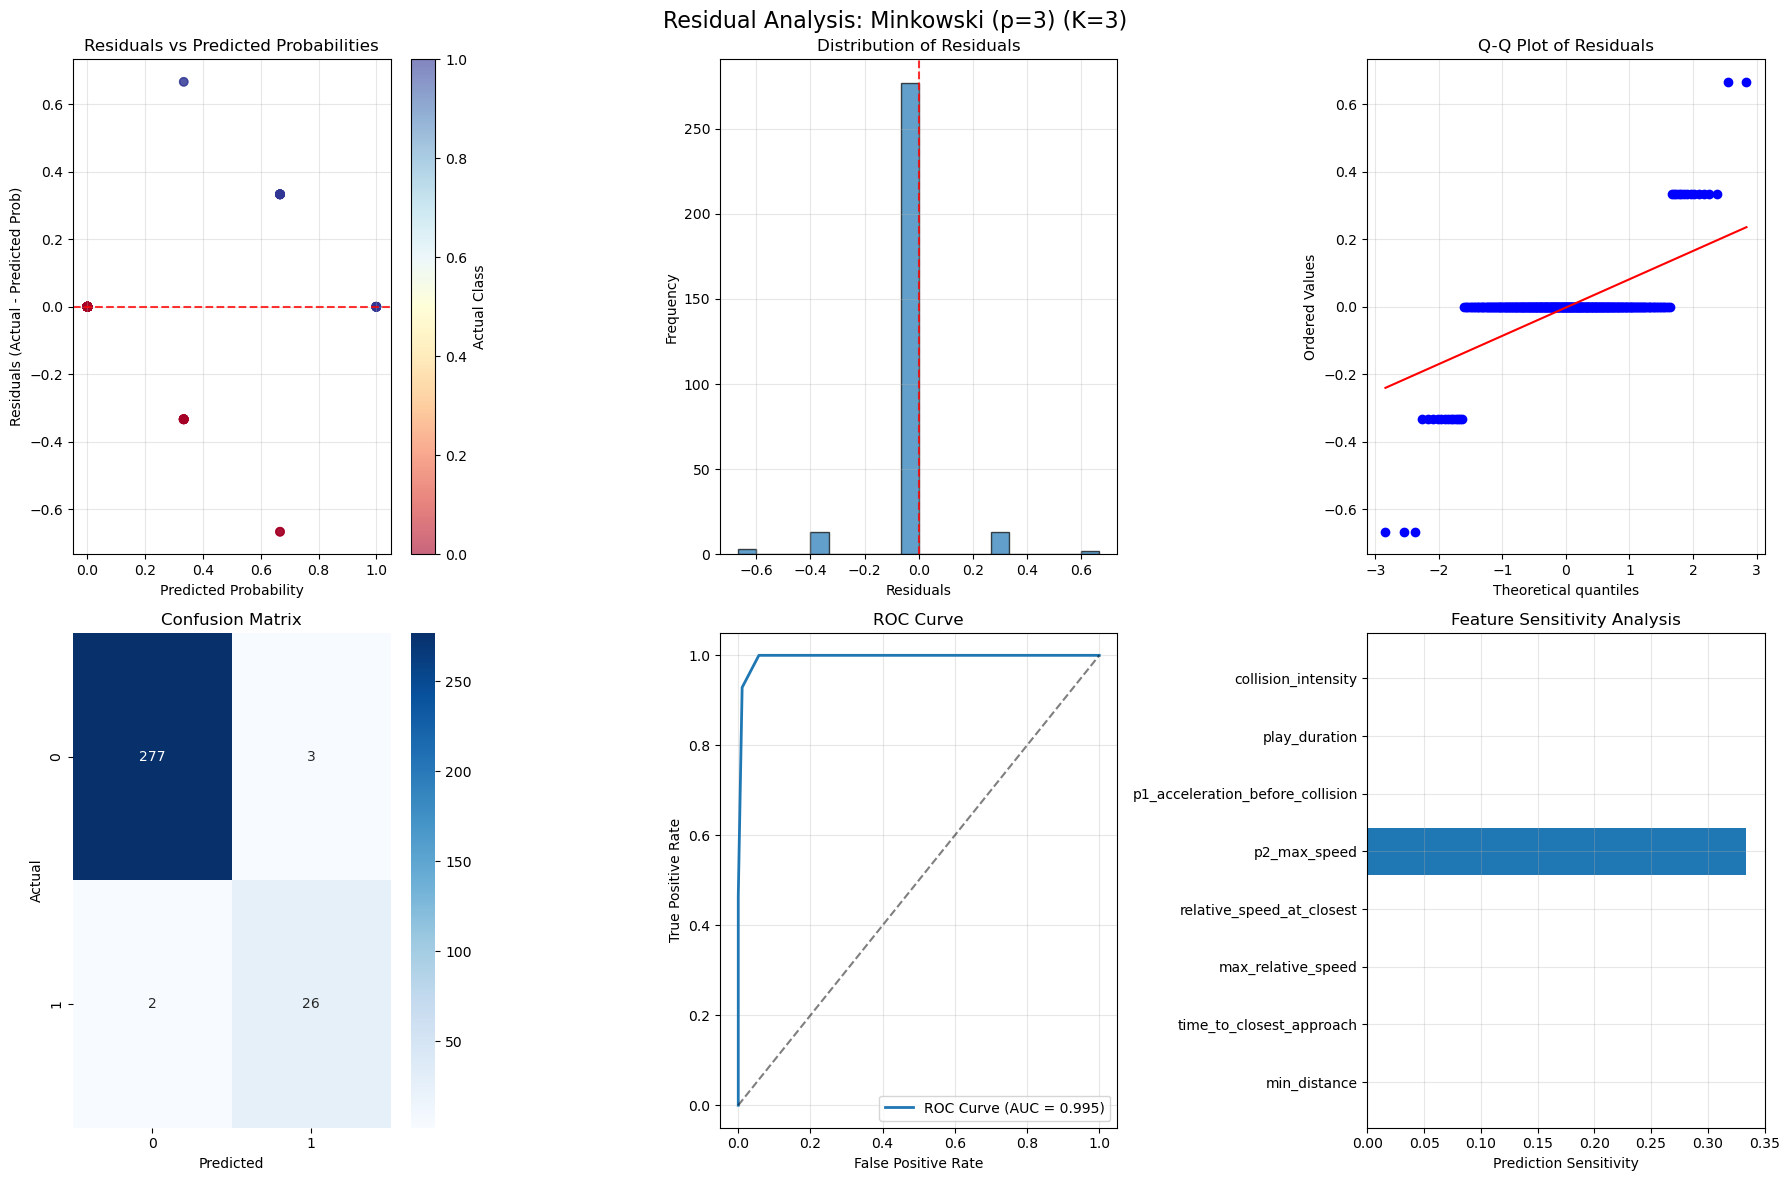


 Detailed Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99       280
      Injury       0.90      0.93      0.91        28

    accuracy                           0.98       308
   macro avg       0.94      0.96      0.95       308
weighted avg       0.98      0.98      0.98       308


 Learning Curve Analysis...


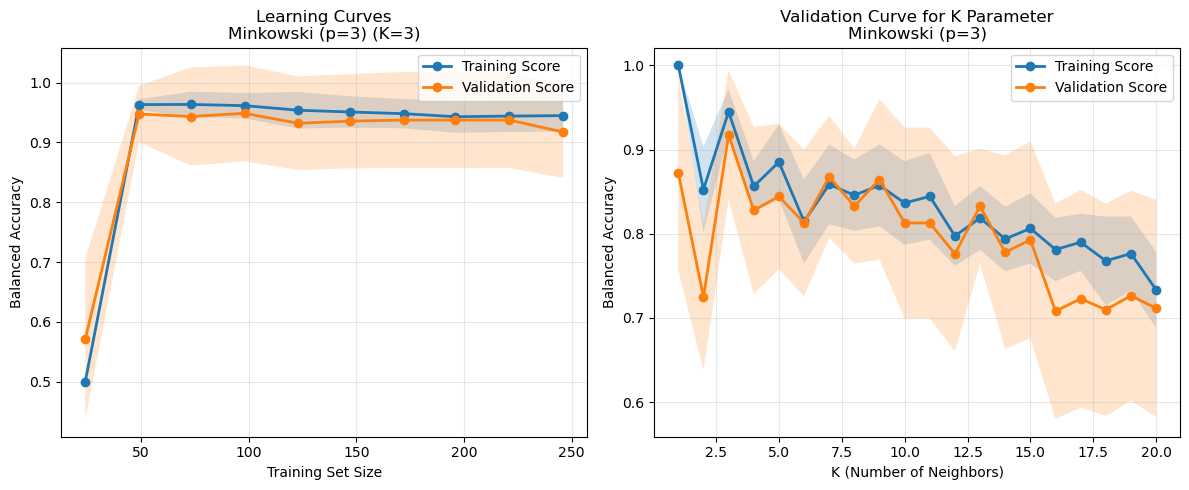

 Knn Analysis Summary

  Distance Metrics Ranking:
   1. Minkowski (p=3) (K=3): 0.899 ± 0.110
   2. Euclidean (L2) (K=1): 0.876 ± 0.060
   3. Euclidean (L2) (K=5): 0.869 ± 0.111
   4. Chebyshev (L_inf) (K=3): 0.869 ± 0.111
   5. Euclidean (L2) (K=7): 0.866 ± 0.102

  Distance Metrics Ranking:
Euclidean (L2):
 Best Performance: 0.876
 Performance Range: 0.100
 Stability (std): 0.032
Manhattan (L1):
 Best Performance: 0.855
 Performance Range: 0.045
 Stability (std): 0.018
Chebyshev (L_inf):
 Best Performance: 0.869
 Performance Range: 0.095
 Stability (std): 0.029
Minkowski (p=3):
 Best Performance: 0.899
 Performance Range: 0.106
 Stability (std): 0.032
Analysis Summary:
   • Most Stable Metric: Manhattan (L1)
   • Best Overall Performance: Minkowski (p=3)
   • Most Successful K Value: 3 (appeared in 4 top configurations)


In [13]:
# Extended K-Nearest Neighbors Analysis and Distance Metrics Evaluation
from sklearn.model_selection import learning_curve, validation_curve
# Evaluate KNN Classifier Performance with different distance metrics
def evaluate_knn_distance_metrics(X, y, feature_names):
    """Evaluate KNN with different distance metrics and hyperparameters"""
    print("\n KNN Distance Metrics Analysis...")
    
    # Distance metrics to test
    distance_metrics = {
        'euclidean': 'Euclidean (L2)',
        'manhattan': 'Manhattan (L1)', 
        'chebyshev': 'Chebyshev (L_inf)',
        'minkowski': 'Minkowski (p=3)'
    }
    
    # K values to test
    k_values = [1, 3, 5, 7, 9, 11, 15]
    results = {}
    
    # Cross-validation setup
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    print(f" Testing {len(distance_metrics)} distance metrics with K values: {k_values}")
    
    for metric_name, metric_display in distance_metrics.items():
        print(f"\n Evaluating {metric_display}...")
        metric_results = {}
        
        for k in k_values:
            # Handle minkowski metric with p parameter
            if metric_name == 'minkowski':
                model = KNeighborsClassifier(
                    n_neighbors=k, 
                    metric=metric_name,
                    p=3,  # p=3 for Minkowski
                    weights='uniform'
                )
            else:
                model = KNeighborsClassifier(
                    n_neighbors=k, 
                    metric=metric_name,
                    weights='uniform'
                )
            
            # Cross-validation scores
            cv_scores = cross_val_score(model, X, y, cv=cv, scoring='balanced_accuracy')
            
            metric_results[k] = {
                'mean_score': cv_scores.mean(),
                'std_score': cv_scores.std(),
                'model': model
            }
            
            print(f"   K={k}: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
        
        results[metric_name] = {
            'display_name': metric_display,
            'results': metric_results
        }
    
    return results

# Run the distance metrics evaluation
distance_results = evaluate_knn_distance_metrics(X_scaled, y, feature_names)

# Visualize distance metrics comparison
def plot_distance_metrics_comparison(distance_results):
    """Plot comparison of different distance metrics"""
    print("\n Creating distance metrics comparison plots...")
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('KNN Performance Across Distance Metrics and K Values', fontsize=16)
    
    # Extract data for plotting
    k_values = list(next(iter(distance_results.values()))['results'].keys())
    
    # Line plot of all metrics
    ax = axes[0, 0]
    for metric_name, metric_data in distance_results.items():
        means = [metric_data['results'][k]['mean_score'] for k in k_values]
        stds = [metric_data['results'][k]['std_score'] for k in k_values]
        
        ax.plot(k_values, means, 'o-', label=metric_data['display_name'], linewidth=2, markersize=6)
        ax.fill_between(k_values, 
                        [m - s for m, s in zip(means, stds)], 
                        [m + s for m, s in zip(means, stds)], 
                        alpha=0.2)
    
    ax.set_xlabel('K (Number of Neighbors)')
    ax.set_ylabel('Balanced Accuracy')
    ax.set_title('Performance vs K Value by Distance Metric')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0.5, 1.0)
    
    # Plot Best performance for each metric
    ax = axes[0, 1]
    metric_names = []
    best_scores = []
    best_k_values = []
    
    for metric_name, metric_data in distance_results.items():
        best_k = max(metric_data['results'].keys(), 
                     key=lambda k: metric_data['results'][k]['mean_score'])
        best_score = metric_data['results'][best_k]['mean_score']
        
        metric_names.append(metric_data['display_name'])
        best_scores.append(best_score)
        best_k_values.append(best_k)
    
    bars = ax.bar(metric_names, best_scores, alpha=0.7, color=['skyblue', 'lightgreen', 'coral', 'gold'])
    ax.set_ylabel('Best Balanced Accuracy')
    ax.set_title('Best Performance by Distance Metric')
    ax.set_ylim(0.7, 1.0)
    
    # Add best K values on bars
    for bar, k_val in zip(bars, best_k_values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'K={k_val}', ha='center', va='bottom', fontweight='bold')
    
    ax.grid(True, alpha=0.3)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    # Plot 3: Heatmap of all results
    ax = axes[1, 0]
    
    # Create heatmap data
    heatmap_data = []
    metric_labels = []
    
    for metric_name, metric_data in distance_results.items():
        scores = [metric_data['results'][k]['mean_score'] for k in k_values]
        heatmap_data.append(scores)
        metric_labels.append(metric_data['display_name'])
    
    heatmap_data = np.array(heatmap_data)
    
    im = ax.imshow(heatmap_data, cmap='RdYlBu_r', aspect='auto')
    ax.set_xticks(range(len(k_values)))
    ax.set_xticklabels(k_values)
    ax.set_yticks(range(len(metric_labels)))
    ax.set_yticklabels(metric_labels)
    ax.set_xlabel('K Value')
    ax.set_ylabel('Distance Metric')
    ax.set_title('Performance Heatmap')
    
    # Add text annotations
    for i in range(len(metric_labels)):
        for j in range(len(k_values)):
            text = ax.text(j, i, f'{heatmap_data[i, j]:.3f}',
                          ha="center", va="center", color="black", fontsize=8)
    
    plt.colorbar(im, ax=ax, label='Balanced Accuracy')
    
    # Plot Standard deviation comparison
    ax = axes[1, 1]
    
    # Calculate average standard deviation for each metric
    avg_stds = []
    for metric_name, metric_data in distance_results.items():
        stds = [metric_data['results'][k]['std_score'] for k in k_values]
        avg_stds.append(np.mean(stds))
    
    bars = ax.bar(metric_labels, avg_stds, alpha=0.7, color=['lightcoral', 'lightblue', 'lightgreen', 'lightyellow'])
    ax.set_ylabel('Average Standard Deviation')
    ax.set_title('Model Stability by Distance Metric')
    ax.grid(True, alpha=0.3)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()

plot_distance_metrics_comparison(distance_results)

# Residual analysis for best KNN model
def perform_residual_analysis(X, y, distance_results, feature_names):
    """Perform residual analysis for the best KNN model"""
    print("\n STEP 7: Residual Analysis for Best KNN Model...")
    
    # Find best model
    best_metric = None
    best_k = None
    best_score = 0
    
    for metric_name, metric_data in distance_results.items():
        for k, results in metric_data['results'].items():
            if results['mean_score'] > best_score:
                best_score = results['mean_score']
                best_metric = metric_name
                best_k = k
    
    print(f" Best model: {distance_results[best_metric]['display_name']} with K={best_k}")
    print(f" Best cross-validation score: {best_score:.3f}")
    
    # Get the best model
    best_model = distance_results[best_metric]['results'][best_k]['model']
    
    # Fit on full dataset for analysis
    best_model.fit(X, y)
    y_pred = best_model.predict(X)
    y_pred_proba = best_model.predict_proba(X)[:, 1]
    
    # Calculate residuals (for classification, we use prediction probabilities)
    residuals = y - y_pred_proba
    
    # Create residual analysis plots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'Residual Analysis: {distance_results[best_metric]["display_name"]} (K={best_k})', fontsize=16)
    
    # Plot 1: Residuals vs Predicted Probabilities
    ax = axes[0, 0]
    scatter = ax.scatter(y_pred_proba, residuals, c=y, cmap='RdYlBu', alpha=0.6)
    ax.axhline(y=0, color='red', linestyle='--', alpha=0.8)
    ax.set_xlabel('Predicted Probability')
    ax.set_ylabel('Residuals (Actual - Predicted Prob)')
    ax.set_title('Residuals vs Predicted Probabilities')
    ax.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax, label='Actual Class')
    
    # Plot 2: Histogram of residuals
    ax = axes[0, 1]
    ax.hist(residuals, bins=20, alpha=0.7, edgecolor='black')
    ax.axvline(x=0, color='red', linestyle='--', alpha=0.8)
    ax.set_xlabel('Residuals')
    ax.set_ylabel('Frequency')
    ax.set_title('Distribution of Residuals')
    ax.grid(True, alpha=0.3)
    
    # Plot 3: Q-Q plot of residuals
    ax = axes[0, 2]
    from scipy import stats
    stats.probplot(residuals, dist="norm", plot=ax)
    ax.set_title('Q-Q Plot of Residuals')
    ax.grid(True, alpha=0.3)
    
    # Plot 4: Confusion Matrix
    ax = axes[1, 0]
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title('Confusion Matrix')
    
    # Plot 5: ROC Curve
    ax = axes[1, 1]
    if len(np.unique(y)) == 2:  # Binary classification
        fpr, tpr, _ = roc_curve(y, y_pred_proba)
        auc_score = roc_auc_score(y, y_pred_proba)
        ax.plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {auc_score:.3f})')
        ax.plot([0, 1], [0, 1], 'k--', alpha=0.5)
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC Curve')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # Plot 6: Feature importance proxy (distance to decision boundary)
    ax = axes[1, 2]
    if len(feature_names) <= 8:  # Only if we have manageable number of features
        # Calculate feature sensitivity by perturbing each feature
        feature_sensitivity = []
        base_pred = best_model.predict_proba(X.mean().values.reshape(1, -1))[0, 1]
        
        for i, feature in enumerate(feature_names):
            X_perturb = X.mean().values.reshape(1, -1)
            X_perturb[0, i] += X.iloc[:, i].std()  # Add one standard deviation
            perturb_pred = best_model.predict_proba(X_perturb)[0, 1]
            sensitivity = abs(perturb_pred - base_pred)
            feature_sensitivity.append(sensitivity)
        
        # Plot feature sensitivity
        bars = ax.barh(range(len(feature_names)), feature_sensitivity)
        ax.set_yticks(range(len(feature_names)))
        ax.set_yticklabels(feature_names)
        ax.set_xlabel('Prediction Sensitivity')
        ax.set_title('Feature Sensitivity Analysis')
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, 'Too many features\nfor sensitivity analysis', 
               ha='center', va='center', transform=ax.transAxes)
        ax.set_title('Feature Sensitivity Analysis')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed classification report
    print(f"\n Detailed Classification Report:")
    print(classification_report(y, y_pred, target_names=['Normal', 'Injury']))
    
    return {
        'best_model': best_model,
        'best_metric': best_metric,
        'best_k': best_k,
        'best_score': best_score,
        'residuals': residuals,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

# Perform residual analysis
residual_analysis = perform_residual_analysis(X_scaled, y, distance_results, feature_names)

# Cell 5: Learning curves to assess overfitting
def plot_learning_curves(X, y, distance_results):
    """Plot learning curves to assess overfitting"""
    print("\n Learning Curve Analysis...")
    
    # Get best model configuration
    best_metric = None
    best_k = None
    best_score = 0
    
    for metric_name, metric_data in distance_results.items():
        for k, results in metric_data['results'].items():
            if results['mean_score'] > best_score:
                best_score = results['mean_score']
                best_metric = metric_name
                best_k = k
    
    best_model = distance_results[best_metric]['results'][best_k]['model']
    
    # Generate learning curves
    train_sizes = np.linspace(0.1, 1.0, 10)
    train_sizes_abs, train_scores, val_scores = learning_curve(
        best_model, X, y, 
        train_sizes=train_sizes,
        cv=5, 
        scoring='balanced_accuracy',
        random_state=42
    )
    
    # Plot learning curves
    plt.figure(figsize=(12, 5))
    
    # Learning curve
    plt.subplot(1, 2, 1)
    plt.plot(train_sizes_abs, np.mean(train_scores, axis=1), 'o-', 
             label='Training Score', linewidth=2, markersize=6)
    plt.fill_between(train_sizes_abs, 
                     np.mean(train_scores, axis=1) - np.std(train_scores, axis=1),
                     np.mean(train_scores, axis=1) + np.std(train_scores, axis=1),
                     alpha=0.2)
    
    plt.plot(train_sizes_abs, np.mean(val_scores, axis=1), 'o-', 
             label='Validation Score', linewidth=2, markersize=6)
    plt.fill_between(train_sizes_abs, 
                     np.mean(val_scores, axis=1) - np.std(val_scores, axis=1),
                     np.mean(val_scores, axis=1) + np.std(val_scores, axis=1),
                     alpha=0.2)
    
    plt.xlabel('Training Set Size')
    plt.ylabel('Balanced Accuracy')
    plt.title(f'Learning Curves\n{distance_results[best_metric]["display_name"]} (K={best_k})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Validation curve for K parameter
    plt.subplot(1, 2, 2)
    k_range = range(1, min(21, len(X)//2))  # Don't exceed reasonable K values
    
    if best_metric == 'minkowski':
        model_for_validation = KNeighborsClassifier(metric=best_metric, p=3)
    else:
        model_for_validation = KNeighborsClassifier(metric=best_metric)
    
    train_scores_k, val_scores_k = validation_curve(
        model_for_validation, X, y,
        param_name='n_neighbors', param_range=k_range,
        cv=5, scoring='balanced_accuracy'
    )
    
    plt.plot(k_range, np.mean(train_scores_k, axis=1), 'o-', 
             label='Training Score', linewidth=2, markersize=6)
    plt.fill_between(k_range, 
                     np.mean(train_scores_k, axis=1) - np.std(train_scores_k, axis=1),
                     np.mean(train_scores_k, axis=1) + np.std(train_scores_k, axis=1),
                     alpha=0.2)
    
    plt.plot(k_range, np.mean(val_scores_k, axis=1), 'o-', 
             label='Validation Score', linewidth=2, markersize=6)
    plt.fill_between(k_range, 
                     np.mean(val_scores_k, axis=1) - np.std(val_scores_k, axis=1),
                     np.mean(val_scores_k, axis=1) + np.std(val_scores_k, axis=1),
                     alpha=0.2)
    
    plt.xlabel('K (Number of Neighbors)')
    plt.ylabel('Balanced Accuracy')
    plt.title(f'Validation Curve for K Parameter\n{distance_results[best_metric]["display_name"]}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Analyze overfitting
    final_train_score = np.mean(train_scores[-1])
    final_val_score = np.mean(val_scores[-1])
    overfitting_gap = final_train_score - final_val_score

# Plot learning curves
plot_learning_curves(X_scaled, y, distance_results)

# Cell 6: Summary of distance metrics and KNN analysis
def summarize_knn_analysis(distance_results, residual_analysis):
    """Create summary of KNN analysis"""
    print(" Knn Analysis Summary")
    
    # Find best performing metric and K
    best_results = []
    for metric_name, metric_data in distance_results.items():
        for k, results in metric_data['results'].items():
            best_results.append({
                'metric': metric_data['display_name'],
                'k': k,
                'score': results['mean_score'],
                'std': results['std_score']
            })
    
    best_results.sort(key=lambda x: x['score'], reverse=True)
    
    print(f"\n  Distance Metrics Ranking:")
    for i, result in enumerate(best_results[:5]):  # Top 5
        print(f"   {i+1}. {result['metric']} (K={result['k']}): "
              f"{result['score']:.3f} ± {result['std']:.3f}")
    
    # Calculate metric-specific insights
    metric_performance = {}
    for metric_name, metric_data in distance_results.items():
        scores = [results['mean_score'] for results in metric_data['results'].values()]
        metric_performance[metric_data['display_name']] = {
            'best': max(scores),
            'worst': min(scores),
            'range': max(scores) - min(scores),
            'stability': np.std(scores)
        }
    
    print(f"\n  Distance Metrics Ranking:")
    for metric, stats in metric_performance.items():
        print(f"{metric}:")
        print(f" Best Performance: {stats['best']:.3f}")
        print(f" Performance Range: {stats['range']:.3f}")
        print(f" Stability (std): {stats['stability']:.3f}")
    
    # Key insights
    print(f"Analysis Summary:")
    
    # Most stable metric
    most_stable = min(metric_performance.keys(), 
                     key=lambda x: metric_performance[x]['stability'])
    print(f"   • Most Stable Metric: {most_stable}")
    
    # Best overall metric
    best_overall = max(metric_performance.keys(), 
                      key=lambda x: metric_performance[x]['best'])
    print(f"   • Best Overall Performance: {best_overall}")
    
    # K value analysis
    k_counts = {}
    for result in best_results:
        k = result['k']
        k_counts[k] = k_counts.get(k, 0) + 1
    
    most_common_k = max(k_counts.keys(), key=lambda x: k_counts[x])
    print(f"   • Most Successful K Value: {most_common_k} (appeared in {k_counts[most_common_k]} top configurations)")

# Generate comprehensive summary
summarize_knn_analysis(distance_results, residual_analysis)

## Dataset 2

In [40]:
def load_play_surface_data():
    """Load the collision feature datasets"""
    print("\n STEP 1: Loading collision feature datasets...")
    
    play_surface_df = pd.read_csv('scripts/play_surface/processed_motion_features.csv')
    
    print(f" Loaded {len(play_surface_df)} plays")
    
    return play_surface_df

play_surface_df = load_play_surface_data()


 STEP 1: Loading collision feature datasets...
 Loaded 266960 plays


<Axes: title={'center': 'Field Type Distribution'}, xlabel='FieldType_Synthetic'>

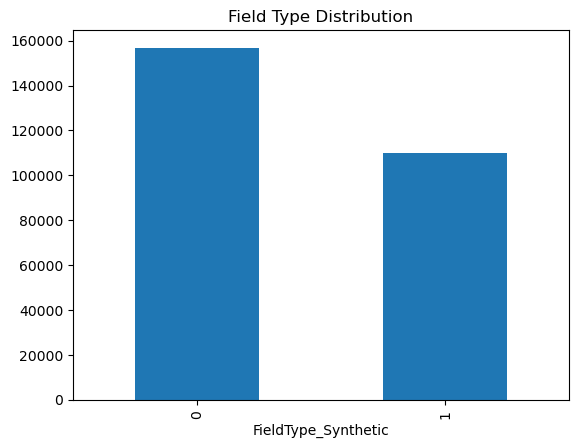

In [43]:
play_surface_df['FieldType_Synthetic'].value_counts().plot(kind='bar', title='Field Type Distribution')

In [60]:
def preprocess_dataset(df, target_col='injury', remove_outliers=False):
    """Preprocessing for injury prediction dataset"""
    print("\n STEP 2: Preprocessing for the play surface dataset...")
    
    # Identify feature columns to exclude
    exclude_cols = [
        # Target variable
        'injury',
        # Days to match variables (future leakage)
        'DM_M1', 'DM_M7', 'DM_M28', 'DM_M42', 
        # Body part information (outcome-related, not predictive features)
        'BodyPart_Foot', 'BodyPart_Heel', 'BodyPart_Knee',
        'BodyPart_Non-Injury', 'BodyPart_Toes',
        # Identifier columns
        'PlayKey', 'PlayerDay', 'PlayerGame',
        # new target
        #'FieldType_Synthetic'
    ]

    # fill class 0 in target column if missing
    if target_col not in df.columns:
        df[target_col] = df[target_col].fillna(0)
    
    feature_cols = [col for col in df.columns if col not in exclude_cols]
    print(f" Identified {len(feature_cols)} potential features")
    
    X = df[feature_cols].copy()
    y = df[target_col].copy()
    
    # Remove features with >50% missing data
    missing_pcts = X.isnull().mean()
    high_missing = missing_pcts[missing_pcts > 0.5].index.tolist()
    if high_missing:
        print(f" Removing {len(high_missing)} features with >50% missing data: {high_missing}")
        X = X.drop(columns=high_missing)
    
    print(f" Features after missing data filter: {X.shape[1]}")
    
    # Handle missing data with appropriate imputation
    print(" Handling missing data...")
    numeric_cols = X.select_dtypes(include=[np.number]).columns
    categorical_cols = X.select_dtypes(include=['object', 'bool']).columns
    
    # Median imputation for numeric features
    for col in numeric_cols:
        if X[col].isnull().any():
            X[col] = X[col].fillna(X[col].median())
    
    # Mode imputation for categorical features
    for col in categorical_cols:
        if X[col].isnull().any():
            X[col] = X[col].fillna(X[col].mode()[0] if not X[col].mode().empty else 0)
    
    # Create engineered features specific to this dataset
    print(" Creating engineered features...")
    
    # Movement intensity score
    if 'max_speed' in X.columns and 'max_acceleration' in X.columns:
        X['movement_intensity'] = (X['max_speed'] / X['max_speed'].max()) * (X['max_acceleration'] / X['max_acceleration'].max())
    
    # Workload indicators
    if 'total_distance' in X.columns and 'play_duration' in X.columns:
        X['distance_per_second'] = X['total_distance'] / (X['play_duration'] + 1e-6)
    
    # Risk indicators based on rapid movements
    if 'rapid_accelerations' in X.columns and 'rapid_decelerations' in X.columns:
        X['total_rapid_movements'] = X['rapid_accelerations'] + X['rapid_decelerations']
    
    # Direction change intensity
    if 'total_direction_change' in X.columns and 'play_duration' in X.columns:
        X['direction_change_rate'] = X['total_direction_change'] / (X['play_duration'] + 1e-6)
    
    # Jerk-based instability indicator
    if 'max_jerk' in X.columns and 'avg_jerk' in X.columns:
        X['jerk_variability'] = X['max_jerk'] / (X['avg_jerk'] + 1e-6)
    
    # Speed consistency
    if 'max_speed' in X.columns and 'avg_speed' in X.columns:
        X['speed_consistency'] = X['avg_speed'] / (X['max_speed'] + 1e-6)
    
    # Fatigue/efficiency indicators
    if 'movement_efficiency' in X.columns and 'time_above_avg_speed' in X.columns:
        X['performance_ratio'] = X['movement_efficiency'] * X['time_above_avg_speed']
    
    # Conservative outlier removal for numeric features only
    if remove_outliers:
        print(" Conservative outlier removal...")
        outlier_mask = np.zeros(len(X), dtype=bool)
        
        for col in X.select_dtypes(include=[np.number]).columns:
            if X[col].std() > 0:  # Only process columns with variation
                Q1 = X[col].quantile(0.05)  # More conservative percentiles
                Q3 = X[col].quantile(0.95)
                IQR = Q3 - Q1
                lower_bound = Q1 - 3 * IQR  # 3 IQR instead of 1.5
                upper_bound = Q3 + 3 * IQR
                
                col_outliers = (X[col] < lower_bound) | (X[col] > upper_bound)
                outlier_mask |= col_outliers
        
        # Only remove if we don't lose too many samples
        outlier_count = outlier_mask.sum()
        if outlier_count < len(X) * 0.3:  # Don't remove more than 30%
            X = X[~outlier_mask]
            y = y[~outlier_mask]
            print(f" Removed {outlier_count} extreme outliers")
        else:
            print(f" Skipping outlier removal (would remove {outlier_count} samples)")
    
    # Ensure all features are numeric for modeling
    print(" Final data type conversion...")
    
    # Convert boolean columns to numeric
    bool_cols = X.select_dtypes(include=['bool']).columns
    for col in bool_cols:
        X[col] = X[col].astype(int)
    
    # Handle any remaining categorical columns
    remaining_categorical = X.select_dtypes(include=['object']).columns
    if len(remaining_categorical) > 0:
        print(f" Converting categorical columns to numeric: {list(remaining_categorical)}")
        from sklearn.preprocessing import LabelEncoder
        le = LabelEncoder()
        for col in remaining_categorical:
            X[col] = le.fit_transform(X[col].astype(str))
    
    print(f" Final dataset: {len(X)} samples, {X.shape[1]} features")
    print(f" Class distribution: {y.value_counts().to_dict()}")
    print(f" Injury rate: {y.mean():.1%}")
    
    # Display feature categories for reference
    movement_features = [col for col in X.columns if any(keyword in col.lower() 
                        for keyword in ['speed', 'acceleration', 'distance', 'jerk'])]
    positional_features = [col for col in X.columns if 'RosterPosition_' in col]
    play_features = [col for col in X.columns if 'PlayType_' in col]
    field_features = [col for col in X.columns if 'FieldType_' in col]
    engineered_features = [col for col in X.columns if any(keyword in col.lower() 
                          for keyword in ['intensity', 'ratio', 'rate', 'consistency', 'variability'])]
    
    print(f"\n Feature categories:")
    print(f"   Movement features: {len(movement_features)}")
    print(f"   Position features: {len(positional_features)}")
    print(f"   Play type features: {len(play_features)}")
    print(f"   Field features: {len(field_features)}")
    print(f"   Engineered features: {len(engineered_features)}")
    
    return X, y

# Usage example:
X, y = preprocess_dataset(play_surface_df, target_col='injury', remove_outliers=False)


 STEP 2: Preprocessing for the play surface dataset...
 Identified 81 potential features
 Features after missing data filter: 81
 Handling missing data...
 Creating engineered features...
 Final data type conversion...
 Final dataset: 266960 samples, 81 features
 Class distribution: {0.0: 266856, 1.0: 104}
 Injury rate: 0.0%

 Feature categories:
   Movement features: 0
   Position features: 9
   Play type features: 11
   Field features: 1
   Engineered features: 0


In [61]:
X_scaled, feature_names, scaler = select_features_small_dataset(X, y, k=20)


 STEP 3: Selecting top 20 features for small dataset...
 Selected features:
   dis_slice_1                    Score: 5.88
   dis_slice_2                    Score: 7.47
   dis_slice_5                    Score: 14.30
   dis_slice_6                    Score: 7.26
   s_slice_1                      Score: 5.39
   s_slice_2                      Score: 7.16
   s_slice_5                      Score: 14.34
   s_slice_6                      Score: 7.87
   x_slice_0                      Score: 8.95
   x_slice_1                      Score: 8.06
   x_slice_2                      Score: 5.51
   x_slice_7                      Score: 4.34
   x_slice_8                      Score: 4.88
   x_slice_9                      Score: 4.91
   RosterPosition_Offensive Lineman Score: 8.66
   RosterPosition_Running Back    Score: 4.58
   FieldType_Synthetic            Score: 6.83
   PlayType_Kickoff               Score: 20.86
   PlayType_Punt                  Score: 20.90
   PlayType_Punt Returned         Score: 9.

In [62]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, accuracy_score, balanced_accuracy_score

def create_resampling_pipeline(X, y, feature_names, 
                              undersample_ratio=0.01, 
                              oversample_ratio=0.1,
                              smote_k=5):
    """Enhanced resampling pipeline with adaptive parameters"""
    print("\n ENHANCED RESAMPLING PIPELINE")
    print("="*50)
    
    # Analyze original data
    original_counts = y.value_counts()
    minority_class = original_counts.min()
    majority_class = original_counts.max()
    imbalance_ratio = minority_class / majority_class
    
    print(f"Original class distribution: {original_counts.to_dict()}")
    print(f"Imbalance ratio: {imbalance_ratio:.4f}")
    print(f"Minority class size: {minority_class}")
    
    # Adaptive parameter selection based on data characteristics
    if minority_class < 10:
        print("  Very small minority class - adjusting parameters...")
        oversample_ratio = min(0.2, oversample_ratio)
        smote_k = min(3, minority_class - 1) if minority_class > 1 else 1
    elif minority_class < 50:
        print("  Small minority class - using conservative oversampling...")
        oversample_ratio = min(0.15, oversample_ratio)
        smote_k = min(5, minority_class - 1)
    
    # Adjust undersampling to not be too aggressive
    if undersample_ratio * majority_class < minority_class * 2:
        undersample_ratio = (minority_class * 2) / majority_class
        print(f"Adjusted undersample ratio to: {undersample_ratio:.3f}")
    
    print(f"\nResampling parameters:")
    print(f"  Undersample ratio: {undersample_ratio:.3f}")
    print(f"  Oversample ratio: {oversample_ratio:.3f}")
    print(f"  SMOTE k_neighbors: {smote_k}")
    
    # Create resampling pipeline
    try:
        undersample = RandomUnderSampler(sampling_strategy=undersample_ratio, random_state=42)
        oversample = SMOTE(sampling_strategy=oversample_ratio, k_neighbors=smote_k, random_state=42)
        
        pipeline = ImbPipeline([
            ('undersample', undersample),
            ('oversample', oversample)
        ])
        
        # Apply resampling
        print("\nApplying resampling...")
        X_resampled, y_resampled = pipeline.fit_resample(X, y)
        
        # Report results
        resampled_counts = pd.Series(y_resampled).value_counts()
        print(f"Resampled distribution: {resampled_counts.to_dict()}")
        print(f"New imbalance ratio: {resampled_counts.min() / resampled_counts.max():.4f}")
        print(f"Data size change: {len(X)} → {len(X_resampled)} samples")
        
        return X_resampled, y_resampled, pipeline
        
    except Exception as e:
        print(f" Resampling failed: {str(e)}")
        print("Falling back to original data...")
        return X, y, None

def evaluate_knn_configurations_proper_validation(X, y, feature_names, 
                                                 test_size=0.2, 
                                                 resampling_params=None):
    """
    Comprehensive KNN evaluation with PROPER validation:
    - Split data first
    - Resample only training data
    - Test on original holdout data
    """
    print("\n COMPREHENSIVE KNN ANALYSIS WITH PROPER VALIDATION")
    print("="*70)
    
    # Default resampling parameters
    if resampling_params is None:
        resampling_params = {
            'undersample_ratio': 0.02,
            'oversample_ratio': 0.15,
            'smote_k': 5
        }
    
    # Step 1: Split original data FIRST (this is crucial!)
    print(" Splitting original data into train/test...")
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )
    
    print(f"Original train set: {len(X_train_orig)} samples")
    print(f"  Class distribution: {pd.Series(y_train_orig).value_counts().to_dict()}")
    print(f"Original test set: {len(X_test_orig)} samples")
    print(f"  Class distribution: {pd.Series(y_test_orig).value_counts().to_dict()}")
    
    # Step 2: Create resampled training data
    print("\n Creating resampled training data...")
    X_train_resampled, y_train_resampled, resampling_pipeline = create_resampling_pipeline(
        X_train_orig, y_train_orig, feature_names, **resampling_params
    )
    
    # Step 3: KNN configuration testing
    print("\n Testing KNN configurations...")
    
    # Distance metrics and K values to test
    distance_metrics = ['euclidean', 'manhattan', 'chebyshev']
    k_values = [3, 5, 7]
    
    # Cross-validation setup
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    results = {
        'cross_validation': {
            'original_train': {},
            'resampled_train': {}
        },
        'holdout_test': {}
    }
    
    # Step 4: Cross-validation on training sets
    print("\n Cross-validation on training data...")
    
    # CV on original training data
    print("\n Cross-validation on ORIGINAL training data:")
    for metric in distance_metrics:
        for k in k_values:
            if k < len(X_train_orig):
                config_name = f"{metric}_k{k}"
                
                try:
                    if metric == 'chebyshev':
                        model = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=np.inf)
                    else:
                        model = KNeighborsClassifier(n_neighbors=k, metric=metric)
                    
                    # Multiple metrics for comprehensive evaluation
                    cv_balanced = cross_val_score(model, X_train_orig, y_train_orig, 
                                                cv=cv, scoring=make_scorer(balanced_accuracy_score))
                    cv_f1 = cross_val_score(model, X_train_orig, y_train_orig, cv=cv, scoring='f1')
                    cv_recall = cross_val_score(model, X_train_orig, y_train_orig, cv=cv, scoring='recall')
                    cv_precision = cross_val_score(model, X_train_orig, y_train_orig, cv=cv, scoring='precision')
                    
                    results['cross_validation']['original_train'][config_name] = {
                        'balanced_accuracy': cv_balanced.mean(),
                        'balanced_accuracy_std': cv_balanced.std(),
                        'f1': cv_f1.mean(),
                        'f1_std': cv_f1.std(),
                        'recall': cv_recall.mean(),
                        'recall_std': cv_recall.std(),
                        'precision': cv_precision.mean(),
                        'precision_std': cv_precision.std(),
                        'distance_metric': metric,
                        'k_value': k
                    }
                    
                    print(f"  {config_name}: Bal_Acc={cv_balanced.mean():.3f}±{cv_balanced.std():.3f}, "
                          f"F1={cv_f1.mean():.3f}, Recall={cv_recall.mean():.3f}")
                    
                except Exception as e:
                    print(f" {config_name}: {str(e)}")

    # CV on resampled training data
    if resampling_pipeline is not None:
        print("\n Cross-validation on RESAMPLED training data:")
        for metric in distance_metrics:
            for k in k_values:
                if k < len(X_train_resampled):
                    config_name = f"{metric}_k{k}"
                    
                    try:
                        if metric == 'chebyshev':
                            model = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=np.inf)
                        else:
                            model = KNeighborsClassifier(n_neighbors=k, metric=metric)
                        
                        cv_balanced = cross_val_score(model, X_train_resampled, y_train_resampled, 
                                                    cv=cv, scoring=make_scorer(balanced_accuracy_score))
                        cv_f1 = cross_val_score(model, X_train_resampled, y_train_resampled, cv=cv, scoring='f1')
                        cv_recall = cross_val_score(model, X_train_resampled, y_train_resampled, cv=cv, scoring='recall')
                        cv_precision = cross_val_score(model, X_train_resampled, y_train_resampled, cv=cv, scoring='precision')
                        
                        results['cross_validation']['resampled_train'][config_name] = {
                            'balanced_accuracy': cv_balanced.mean(),
                            'balanced_accuracy_std': cv_balanced.std(),
                            'f1': cv_f1.mean(),
                            'f1_std': cv_f1.std(),
                            'recall': cv_recall.mean(),
                            'recall_std': cv_recall.std(),
                            'precision': cv_precision.mean(),
                            'precision_std': cv_precision.std(),
                            'distance_metric': metric,
                            'k_value': k
                        }
                        
                        print(f"  {config_name}: Bal_Acc={cv_balanced.mean():.3f}±{cv_balanced.std():.3f}, "
                              f"F1={cv_f1.mean():.3f}, Recall={cv_recall.mean():.3f}")
                        
                    except Exception as e:
                        print(f" {config_name}: {str(e)}")

    # Step 5: Final evaluation on original holdout test set
    print("\nFINAL EVALUATION ON ORIGINAL HOLDOUT TEST SET")
    print("="*60)
    
    # Find best configurations from CV
    orig_cv_results = results['cross_validation']['original_train']
    resamp_cv_results = results['cross_validation']['resampled_train']
    
    if orig_cv_results:
        best_orig_config = max(orig_cv_results.keys(), 
                              key=lambda x: orig_cv_results[x]['balanced_accuracy'])
        print(f"Best original config (from CV): {best_orig_config}")
        print(f"  CV Balanced Accuracy: {orig_cv_results[best_orig_config]['balanced_accuracy']:.3f}")
    else:
        best_orig_config = 'euclidean_k3'
        print(" No successful original configs, using default")
    
    if resamp_cv_results:
        best_resamp_config = max(resamp_cv_results.keys(), 
                                key=lambda x: resamp_cv_results[x]['balanced_accuracy'])
        print(f"Best resampled config (from CV): {best_resamp_config}")
        print(f"  CV Balanced Accuracy: {resamp_cv_results[best_resamp_config]['balanced_accuracy']:.3f}")
    else:
        best_resamp_config = 'euclidean_k3'
        print("No successful resampled configs, using default")
    
    # Test both models on original holdout test set
    configs_to_test = []
    
    if orig_cv_results:
        configs_to_test.append(('Original_Model', best_orig_config, X_train_orig, y_train_orig))
    
    if resamp_cv_results and resampling_pipeline is not None:
        configs_to_test.append(('Resampled_Model', best_resamp_config, X_train_resampled, y_train_resampled))
    
    best_model = None
    best_model_name = None
    
    for model_name, config, X_train, y_train in configs_to_test:
        print(f"\n Testing {model_name} ({config}) on original holdout test set...")
        
        # Parse config
        parts = config.split('_')
        metric = parts[0]
        k = int(parts[1][1:])
        
        try:
            # Create and train model
            if metric == 'chebyshev':
                model = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=np.inf)
            else:
                model = KNeighborsClassifier(n_neighbors=k, metric=metric)
            
            model.fit(X_train, y_train)
            
            # Predict on original test set
            y_pred = model.predict(X_test_orig)
            y_pred_proba = model.predict_proba(X_test_orig)[:, 1]
            
            # Calculate metrics
            bal_acc = balanced_accuracy_score(y_test_orig, y_pred)
            
            # Classification report
            report = classification_report(y_test_orig, y_pred, output_dict=True, zero_division=0)
            
            results['holdout_test'][model_name] = {
                'config': config,
                'balanced_accuracy': bal_acc,
                'precision': report['1.0']['precision'] if '1.0' in report else 0,
                'recall': report['1.0']['recall'] if '1.0' in report else 0,
                'f1': report['1.0']['f1-score'] if '1.0' in report else 0,
                'model': model,
                'predictions': y_pred,
                'probabilities': y_pred_proba,
                'distance_metric': metric,
                'k_value': k
            }
            
            print(f" Balanced Accuracy: {bal_acc:.3f}")
            print(f" Precision: {results['holdout_test'][model_name]['precision']:.3f}")
            print(f" Recall: {results['holdout_test'][model_name]['recall']:.3f}")
            print(f" F1 Score: {results['holdout_test'][model_name]['f1']:.3f}")
            
            # Update best model
            if best_model is None or bal_acc > results['holdout_test'][best_model_name]['balanced_accuracy']:
                best_model = model
                best_model_name = model_name
            
        except Exception as e:
            print(f" Error: {e}")
            results['holdout_test'][model_name] = {'error': str(e)}
    
    # Step 6: Final comparison and recommendations
    print("\nFINAL COMPARISON & RECOMMENDATIONS")
    print("="*50)
    
    holdout_results = results['holdout_test']
    
    if len([r for r in holdout_results.values() if 'error' not in r]) >= 2:
        orig_results = holdout_results.get('Original_Model', {})
        resamp_results = holdout_results.get('Resampled_Model', {})
        
        if 'error' not in orig_results and 'error' not in resamp_results:
            print("\nPERFORMANCE ON ORIGINAL HOLDOUT TEST SET:")
            print(f"Original Model ({orig_results['config']}):")
            print(f"  Balanced Accuracy: {orig_results['balanced_accuracy']:.3f}")
            print(f"  Recall: {orig_results['recall']:.3f}")
            print(f"  F1 Score: {orig_results['f1']:.3f}")
            print(f"  Precision: {orig_results['precision']:.3f}")
            
            print(f"\nResampled Model ({resamp_results['config']}):")
            print(f"  Balanced Accuracy: {resamp_results['balanced_accuracy']:.3f}")
            print(f"  Recall: {resamp_results['recall']:.3f}")
            print(f"  F1 Score: {resamp_results['f1']:.3f}")
            print(f"  Precision: {resamp_results['precision']:.3f}")
            
            # Improvements
            bal_acc_improvement = resamp_results['balanced_accuracy'] - orig_results['balanced_accuracy']
            recall_improvement = resamp_results['recall'] - orig_results['recall']
            f1_improvement = resamp_results['f1'] - orig_results['f1']
            
            print(f"\nIMPROVEMENT FROM RESAMPLING:")
            print(f"  Balanced Accuracy: {bal_acc_improvement:+.3f}")
            print(f"  Recall: {recall_improvement:+.3f}")
            print(f"  F1 Score: {f1_improvement:+.3f}")
        
        # Distance metric analysis
        print(f"\nDISTANCE METRIC INSIGHTS:")
        for dataset_name, dataset_results in results['cross_validation'].items():
            if dataset_results:
                print(f"\n{dataset_name.replace('_', ' ').title()}:")
                
                metric_performance = {}
                for config, result in dataset_results.items():
                    metric = result['distance_metric']
                    if metric not in metric_performance:
                        metric_performance[metric] = []
                    metric_performance[metric].append(result['balanced_accuracy'])
                
                for metric, scores in metric_performance.items():
                    avg_score = np.mean(scores)
                    max_score = np.max(scores)
                    print(f"  {metric.capitalize()}: Avg={avg_score:.3f}, Best={max_score:.3f}")
    
    else:
        print("Insufficient results for comparison")

    print(f"\n FINAL BEST MODEL: {best_model_name}")
    if best_model_name and best_model_name in holdout_results:
        best_config = holdout_results[best_model_name]
        print(f"  Configuration: {best_config['config']}")
        print(f"  Balanced Accuracy: {best_config['balanced_accuracy']:.3f}")
        print(f"  Distance Metric: {best_config['distance_metric']}")
        print(f"  K Value: {best_config['k_value']}")
    
    return results, best_model, best_model_name, resampling_pipeline

# Usage functions
def run_comprehensive_knn_analysis(X_scaled, y, feature_names):
    """Run the complete KNN analysis with proper validation"""
    return evaluate_knn_configurations_proper_validation(X_scaled, y, feature_names)

def run_custom_resampling_analysis(X_scaled, y, feature_names):
    """Run with custom resampling parameters"""
    custom_params = {
        'undersample_ratio': 0.02,  # Less aggressive undersampling
        'oversample_ratio': 0.15,   # More conservative oversampling
        'smote_k': 3                # Lower K for SMOTE
    }
    
    return evaluate_knn_configurations_proper_validation(
        X_scaled, y, feature_names, resampling_params=custom_params
    )

# Final usage:
results, best_model, best_model_name, pipeline = run_comprehensive_knn_analysis(X_scaled, y, feature_names)


 COMPREHENSIVE KNN ANALYSIS WITH PROPER VALIDATION
 Splitting original data into train/test...
Original train set: 213568 samples
  Class distribution: {0.0: 213485, 1.0: 83}
Original test set: 53392 samples
  Class distribution: {0.0: 53371, 1.0: 21}

 Creating resampled training data...

 ENHANCED RESAMPLING PIPELINE
Original class distribution: {0.0: 213485, 1.0: 83}
Imbalance ratio: 0.0004
Minority class size: 83

Resampling parameters:
  Undersample ratio: 0.020
  Oversample ratio: 0.150
  SMOTE k_neighbors: 5

Applying resampling...
Resampled distribution: {0.0: 4150, 1.0: 622}
New imbalance ratio: 0.1499
Data size change: 213568 → 4772 samples

 Testing KNN configurations...

 Cross-validation on training data...

 Cross-validation on ORIGINAL training data:
  euclidean_k3: Bal_Acc=0.500±0.000, F1=0.000, Recall=0.000
  euclidean_k5: Bal_Acc=0.500±0.000, F1=0.000, Recall=0.000
  euclidean_k7: Bal_Acc=0.500±0.000, F1=0.000, Recall=0.000
  manhattan_k3: Bal_Acc=0.500±0.000, F1=0.0

In [40]:
# perform distance analysis on dataset 2
distance_results = evaluate_knn_distance_metrics(X_scaled, y, feature_names)


 STEP 6: Comprehensive KNN Distance Metrics Analysis...
 Testing 4 distance metrics with K values: [1, 3, 5, 7, 9, 11, 15]

 Evaluating Euclidean (L2)...
   K=1: 0.500 ± 0.000
   K=3: 0.500 ± 0.000
   K=5: 0.500 ± 0.000
   K=7: 0.500 ± 0.000
   K=9: 0.500 ± 0.000
   K=11: 0.500 ± 0.000
   K=15: 0.500 ± 0.000

 Evaluating Manhattan (L1)...
   K=1: 0.500 ± 0.000
   K=3: 0.500 ± 0.000
   K=5: 0.500 ± 0.000
   K=7: 0.500 ± 0.000
   K=9: 0.500 ± 0.000
   K=11: 0.500 ± 0.000
   K=15: 0.500 ± 0.000

 Evaluating Chebyshev (L∞)...
   K=1: 0.500 ± 0.000
   K=3: 0.500 ± 0.000
   K=5: 0.500 ± 0.000
   K=7: 0.500 ± 0.000
   K=9: 0.500 ± 0.000
   K=11: 0.500 ± 0.000
   K=15: 0.500 ± 0.000

 Evaluating Minkowski (p=3)...


KeyboardInterrupt: 

In [ ]:
# plot distance metrics comparison for dataset 2
plot_distance_metrics_comparison(distance_results)

In [ ]:
# learning curve analysis for dataset 2

In [39]:
# Perform residual analysis
residual_analysis = perform_residual_analysis(X_scaled, y, distance_results, feature_names)


 STEP 7: Residual Analysis for Best KNN Model...
 Best model: Manhattan (L1) with K=5
 Best cross-validation score: 0.914


KeyboardInterrupt: 

## Dataset 3

In [35]:
from sklearn.preprocessing import StandardScaler
# data already preprocessed due to outliers removed in test/train set
X_test = pd.read_csv('scripts/big_data_bowl/X_test.csv')
X_train = pd.read_csv('scripts/big_data_bowl/X_train.csv')
y_train = pd.read_csv('scripts/big_data_bowl/y_train.csv')
y_test = pd.read_csv('scripts/big_data_bowl/y_test.csv')
X_holdout = pd.read_csv('scripts/big_data_bowl/X_holdout.csv')
y_holdout = pd.read_csv('scripts/big_data_bowl/y_holdout.csv')

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_holdout_scaled = scaler.transform(X_holdout)

In [36]:
from sklearn.feature_selection import SelectKBest, f_regression
def select_features_small_dataset_regression(X, y, k=8):
    """Feature selection optimized for small datasets with KNN regression"""
    print(f"\n STEP 3: Selecting top {k} features for small dataset (regression)...")
    
    # Use fewer features for small datasets to avoid overfitting
    # For regression, we can be slightly more generous with features
    k = min(k, X.shape[1], len(y) // 2)  # Rule: max features = samples/2 for regression
    
    if X.shape[1] > k:
        # Use f_regression instead of f_classif for regression tasks
        selector = SelectKBest(score_func=f_regression, k=k)
        X_selected = selector.fit_transform(X, y)
        
        selected_features = X.columns[selector.get_support()].tolist()
        feature_scores = selector.scores_[selector.get_support()]
        
        print(" Selected features (regression scores):")
        for feature, score in zip(selected_features, feature_scores):
            print(f"   {feature:<30} F-score: {score:.2f}")
        
        X_selected = pd.DataFrame(X_selected, columns=selected_features, index=X.index)
    else:
        X_selected = X
        selected_features = X.columns.tolist()
        print(" Using all features (dataset smaller than k)")
    
    print(" Features already scaled - skipping scaling step...")
    
    return X_selected, selected_features

# Usage updated to reflect no scaler return
X_selected, feature_names = select_features_small_dataset_regression(X_train, y_train, k=20)


 STEP 3: Selecting top 20 features for small dataset (regression)...
 Selected features (regression scores):
   down                           F-score: 20.50
   passResult_I                   F-score: 1239.64
   passResult_IN                  F-score: 62.42
   passResult_R                   F-score: 17.70
   passResult_S                   F-score: 1057.59
   dropBackType_TRADITIONAL       F-score: 12.96
   pff_passCoverage_Red Zone      F-score: 43.16
   pff_passCoverageType_Other     F-score: 49.60
   pff_passCoverageType_Zone      F-score: 21.93
   yardsToGo                      F-score: 18.14
   yardlineNumber                 F-score: 21.17
   prePenaltyPlayResult           F-score: 15215.24
   pff_playAction                 F-score: 10.12
   RB_offensecount                F-score: 7.94
   pff_hit                        F-score: 15.28
   pff_hurry                      F-score: 105.20
   pff_sack                       F-score: 901.01
   pff_hitAllowed                 F-score: 8.08
 

In [37]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score, KFold, LeaveOneOut
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
import numpy as np

def evaluate_models_small_dataset_regression(X, y, feature_names):
    """Model evaluation optimized for small datasets using cross-validation for regression"""
    print("\n STEP 4: Model evaluation with cross-validation (regression)...")
    
    # KNN regressor configurations for small datasets
    models = {
        'KNN_3': KNeighborsRegressor(
            n_neighbors=3, weights='uniform', algorithm='auto'
        ),
        'KNN_5': KNeighborsRegressor(
            n_neighbors=5, weights='distance', algorithm='auto'  # distance weighting often better for regression
        ),
        'KNN_7': KNeighborsRegressor(
            n_neighbors=7, weights='distance', algorithm='auto'
        )
    }
    
    print(f" Dataset: {len(X)} samples, {X.shape[1]} features")
    print(f" Target variable stats: mean={float(y.mean()):.3f}, std={float(y.std()):.3f}, range=[{float(y.min()):.3f}, {float(y.max()):.3f}]")
    
    # Use Leave-One-Out CV for very small datasets, regular K-Fold otherwise
    if len(X) < 30:
        cv = LeaveOneOut()
        cv_name = "Leave-One-Out"
    else:
        cv = KFold(n_splits=min(5, len(y)//2), shuffle=True, random_state=42)
        cv_name = "K-Fold"
    
    print(f" Using {cv_name} cross-validation...")
    
    results = {}
    
    for name, model in models.items():
        print(f"\n Evaluating {name}...")
        
        try:
            # Cross-validation scores for regression metrics
            cv_scores_r2 = cross_val_score(model, X, y, cv=cv, scoring='r2')
            cv_scores_neg_mse = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
            cv_scores_neg_mae = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_error')
            
            # Convert negative scores back to positive
            cv_scores_mse = -cv_scores_neg_mse
            cv_scores_mae = -cv_scores_neg_mae
            cv_scores_rmse = np.sqrt(cv_scores_mse)
            
            # Fit model on full dataset for analysis
            model.fit(X, y)
            y_pred = model.predict(X)
            
            results[name] = {
                'model': model,
                'cv_r2': cv_scores_r2,
                'cv_mse': cv_scores_mse,
                'cv_mae': cv_scores_mae,
                'cv_rmse': cv_scores_rmse,
                'mean_r2': cv_scores_r2.mean(),
                'mean_mse': cv_scores_mse.mean(),
                'mean_mae': cv_scores_mae.mean(),
                'mean_rmse': cv_scores_rmse.mean(),
                'y_pred': y_pred
            }
            
            print(f"   R² Score: {cv_scores_r2.mean():.3f} ± {cv_scores_r2.std():.3f}")
            print(f"   RMSE: {cv_scores_rmse.mean():.3f} ± {cv_scores_rmse.std():.3f}")
            print(f"   MAE: {cv_scores_mae.mean():.3f} ± {cv_scores_mae.std():.3f}")
            
            # Additional metrics on full dataset fit
            full_r2 = r2_score(y, y_pred)
            full_rmse = np.sqrt(mean_squared_error(y, y_pred))
            full_mae = mean_absolute_error(y, y_pred)
            print(f"   Full dataset - R²: {full_r2:.3f}, RMSE: {full_rmse:.3f}, MAE: {full_mae:.3f}")
            
        except Exception as e:
            print(f"    Error evaluating {name}: {str(e)}")
            results[name] = {'error': str(e)}
    
    # Find best model based on R² score
    valid_results = {k: v for k, v in results.items() if 'error' not in v}
    if valid_results:
        best_model_name = max(valid_results.keys(), key=lambda x: valid_results[x]['mean_r2'])
        best_model = valid_results[best_model_name]['model']
        print(f"\n Best model: {best_model_name} (highest R² score)")
        print(f" Best R² score: {valid_results[best_model_name]['mean_r2']:.3f}")
    else:
        best_model_name = list(results.keys())[0]
        best_model = None
        print("\n No models evaluated successfully")
    
    return results, best_model, best_model_name

# Usage
results, best_model, best_model_name = evaluate_models_small_dataset_regression(X_selected, y_train, feature_names)


 STEP 4: Model evaluation with cross-validation (regression)...
 Dataset: 5863 samples, 20 features
 Target variable stats: mean=5.176, std=7.712, range=[-16.000, 27.000]
 Using K-Fold cross-validation...

 Evaluating KNN_3...
   R² Score: 0.717 ± 0.084
   RMSE: 4.054 ± 0.544
   MAE: 1.576 ± 0.180
   Full dataset - R²: 0.863, RMSE: 2.852, MAE: 1.048

 Evaluating KNN_5...
   R² Score: 0.734 ± 0.081
   RMSE: 3.926 ± 0.540
   MAE: 1.547 ± 0.159
   Full dataset - R²: 0.997, RMSE: 0.436, MAE: 0.025

 Evaluating KNN_7...
   R² Score: 0.738 ± 0.080
   RMSE: 3.901 ± 0.535
   MAE: 1.546 ± 0.144
   Full dataset - R²: 0.997, RMSE: 0.428, MAE: 0.026

 Best model: KNN_7 (highest R² score)
 Best R² score: 0.738



 STEP 5: Analysis for small dataset (regression)...
 Skipping feature correlation analysis (will focus on model performance)...
 Creating visualizations...


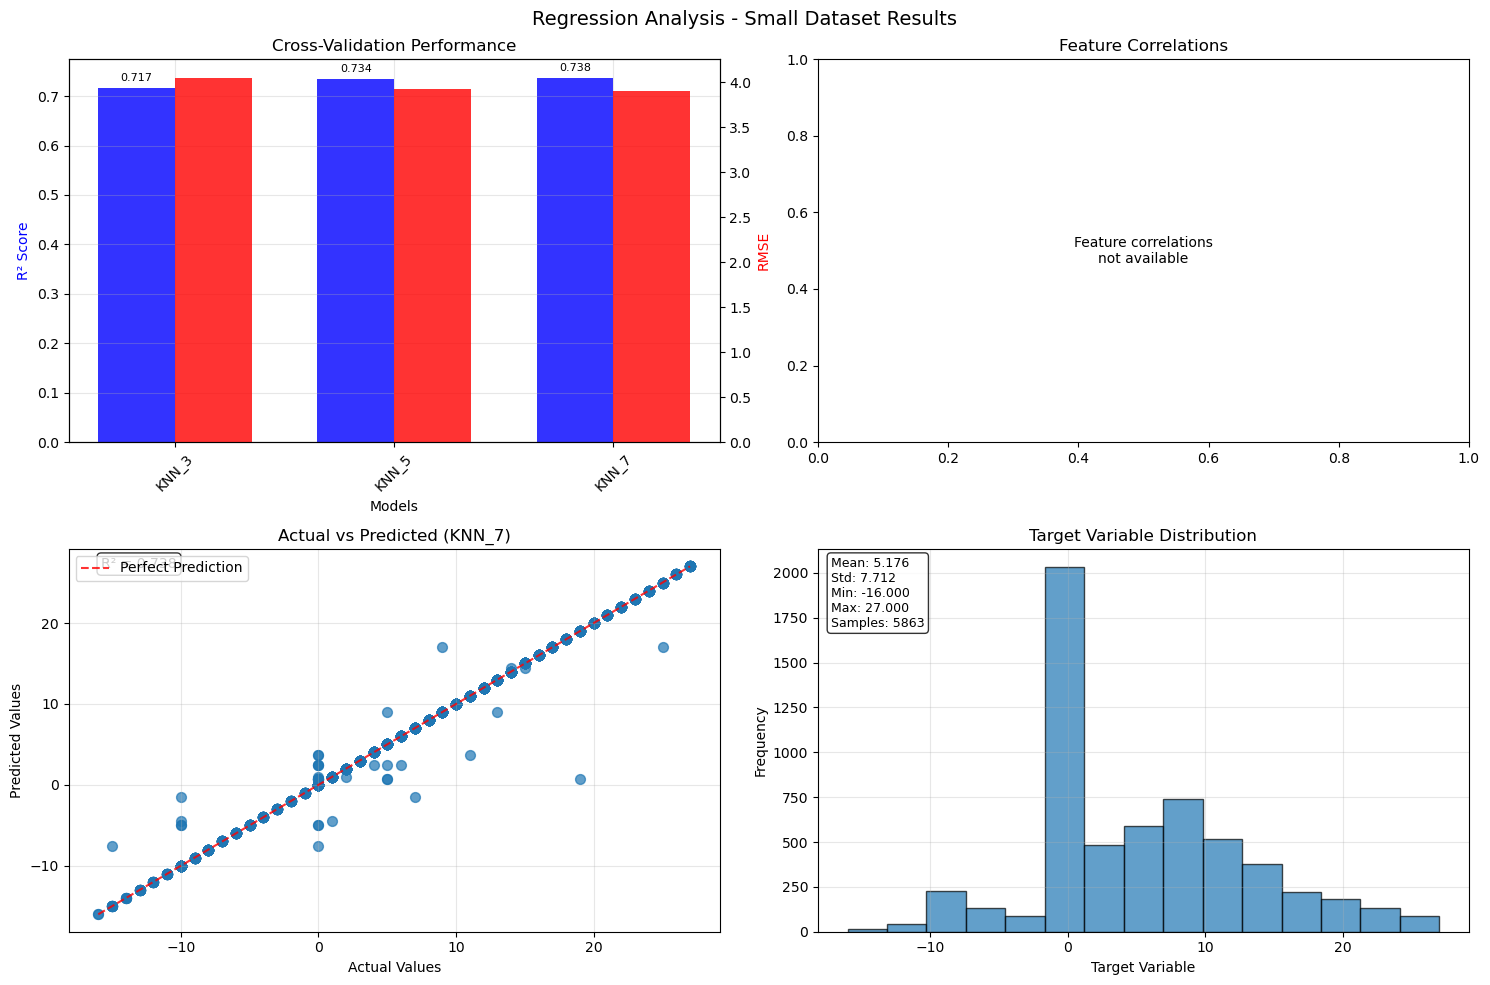


 Summary:
 Best model: KNN_7
 Best R² score: 0.738
 Best RMSE: 3.901


In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

def analyze_small_dataset_results_regression(results, X, y, feature_names, best_model, best_model_name):
    """Analysis and visualization for small datasets with regression"""
    print("\n STEP 5: Analysis for small dataset (regression)...")
    
    # Feature importance analysis for KNN regression
    # Since KNN correlation analysis is proving problematic, let's skip it for now
    print(" Skipping feature correlation analysis (will focus on model performance)...")
    feature_importance = None
    
    # Visualizations for regression
    print(" Creating visualizations...")
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Regression Analysis - Small Dataset Results', fontsize=14)
    
    # 1. Cross-validation scores comparison (R² and RMSE)
    ax = axes[0, 0]
    valid_results = {k: v for k, v in results.items() if 'error' not in v}
    
    if valid_results:
        model_names = list(valid_results.keys())
        r2_scores = [valid_results[name]['mean_r2'] for name in model_names]
        rmse_scores = [valid_results[name]['mean_rmse'] for name in model_names]
        
        x = np.arange(len(model_names))
        width = 0.35
        
        # Create twin axis for different scales
        ax2 = ax.twinx()
        
        bars1 = ax.bar(x - width/2, r2_scores, width, label='R² Score', alpha=0.8, color='blue')
        bars2 = ax2.bar(x + width/2, rmse_scores, width, label='RMSE', alpha=0.8, color='red')
        
        ax.set_xlabel('Models')
        ax.set_ylabel('R² Score', color='blue')
        ax2.set_ylabel('RMSE', color='red')
        ax.set_title('Cross-Validation Performance')
        ax.set_xticks(x)
        ax.set_xticklabels(model_names, rotation=45)
        
        # Add value labels on bars
        for bar, value in zip(bars1, r2_scores):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                   f'{value:.3f}', ha='center', va='bottom', fontsize=8)
        
        ax.grid(True, alpha=0.3)
    
    # 2. Feature correlations
    ax = axes[0, 1]
    if feature_importance is not None and len(feature_importance) > 0:
        # Show top features only to avoid overcrowding
        top_features = feature_importance.head(min(10, len(feature_importance)))
        bars = ax.barh(range(len(top_features)), top_features['correlation'])
        ax.set_yticks(range(len(top_features)))
        ax.set_yticklabels(top_features['feature'])
        ax.set_xlabel('|Correlation| with Target')
        ax.set_title('Feature Correlations')
        ax.grid(True, alpha=0.3)
        
        # Color bars by correlation strength
        for i, (_, row) in enumerate(top_features.iterrows()):
            if row['correlation'] > 0.5:
                bars[i].set_color('darkgreen')
            elif row['correlation'] > 0.3:
                bars[i].set_color('orange')
            else:
                bars[i].set_color('lightcoral')
    else:
        ax.text(0.5, 0.5, 'Feature correlations\nnot available', 
               ha='center', va='center', transform=ax.transAxes)
        ax.set_title('Feature Correlations')
    
    # 3. Actual vs Predicted for best model
    ax = axes[1, 0]
    if best_model is not None and best_model_name in valid_results:
        y_pred = valid_results[best_model_name]['y_pred']
        
        ax.scatter(y, y_pred, alpha=0.7, s=50)
        
        # Perfect prediction line
        min_val = min(float(y.min()), float(y_pred.min()))
        max_val = max(float(y.max()), float(y_pred.max()))
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, label='Perfect Prediction')
        
        ax.set_xlabel('Actual Values')
        ax.set_ylabel('Predicted Values')
        ax.set_title(f'Actual vs Predicted ({best_model_name})')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Add R² score as text
        r2 = valid_results[best_model_name]['mean_r2']
        ax.text(0.05, 0.95, f'R² = {r2:.3f}', transform=ax.transAxes, 
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # 4. Target variable distribution and summary stats
    ax = axes[1, 1]
    ax.hist(y, bins=min(15, len(y)//2), alpha=0.7, edgecolor='black')
    ax.set_xlabel('Target Variable')
    ax.set_ylabel('Frequency')
    ax.set_title('Target Variable Distribution')
    ax.grid(True, alpha=0.3)
    
    # Add summary statistics as text
    stats_text = f'Mean: {float(y.mean()):.3f}\nStd: {float(y.std()):.3f}\nMin: {float(y.min()):.3f}\nMax: {float(y.max()):.3f}\nSamples: {len(y)}'
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8), fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\n Summary:")
    print(f" Best model: {best_model_name}")
    if best_model_name in valid_results:
        print(f" Best R² score: {valid_results[best_model_name]['mean_r2']:.3f}")
        print(f" Best RMSE: {valid_results[best_model_name]['mean_rmse']:.3f}")
    
    return feature_importance

# Usage
feature_importance = analyze_small_dataset_results_regression(results, X_selected, y_train, feature_names, best_model, best_model_name)


 KNN Regression Distance Metrics Analysis...
 Testing 4 distance metrics with K values: [1, 3, 5, 7, 9, 11, 15]

 Evaluating Euclidean (L2)...
   K=1: R²=0.603 ± 0.084, RMSE=4.822 ± 0.413
   K=3: R²=0.717 ± 0.084, RMSE=4.054 ± 0.544
   K=5: R²=0.735 ± 0.081, RMSE=3.923 ± 0.536
   K=7: R²=0.737 ± 0.080, RMSE=3.907 ± 0.528
   K=9: R²=0.739 ± 0.076, RMSE=3.891 ± 0.511
   K=11: R²=0.740 ± 0.073, RMSE=3.887 ± 0.494
   K=15: R²=0.743 ± 0.073, RMSE=3.864 ± 0.489

 Evaluating Manhattan (L1)...
   K=1: R²=0.606 ± 0.074, RMSE=4.811 ± 0.399
   K=3: R²=0.716 ± 0.087, RMSE=4.055 ± 0.561
   K=5: R²=0.735 ± 0.076, RMSE=3.923 ± 0.512
   K=7: R²=0.743 ± 0.075, RMSE=3.866 ± 0.514
   K=9: R²=0.747 ± 0.072, RMSE=3.835 ± 0.504
   K=11: R²=0.748 ± 0.072, RMSE=3.828 ± 0.498
   K=15: R²=0.748 ± 0.071, RMSE=3.826 ± 0.493

 Evaluating Chebyshev (L_inf)...
   K=1: R²=0.578 ± 0.084, RMSE=4.978 ± 0.453
   K=3: R²=0.702 ± 0.073, RMSE=4.171 ± 0.445
   K=5: R²=0.726 ± 0.073, RMSE=3.996 ± 0.487
   K=7: R²=0.733 ± 0.0

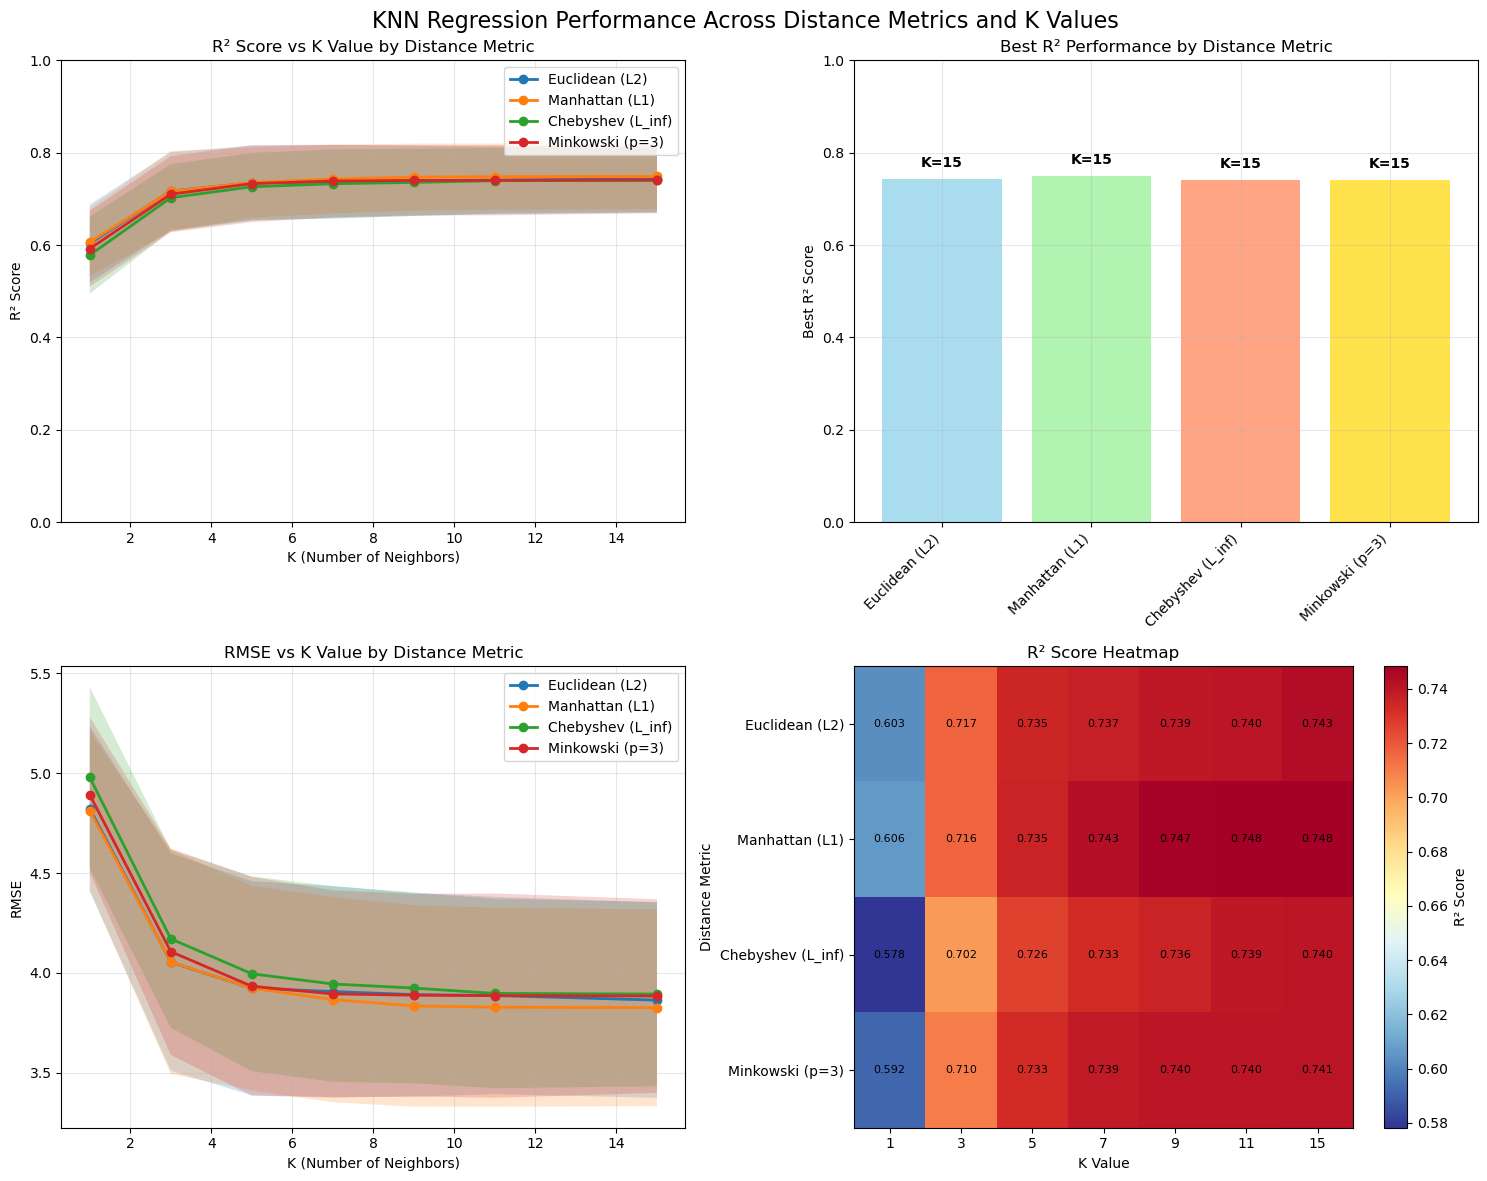


 STEP 7: Residual Analysis for Best KNN Regression Model...
 Best model: Manhattan (L1) with K=15
 Best cross-validation R² score: 0.748


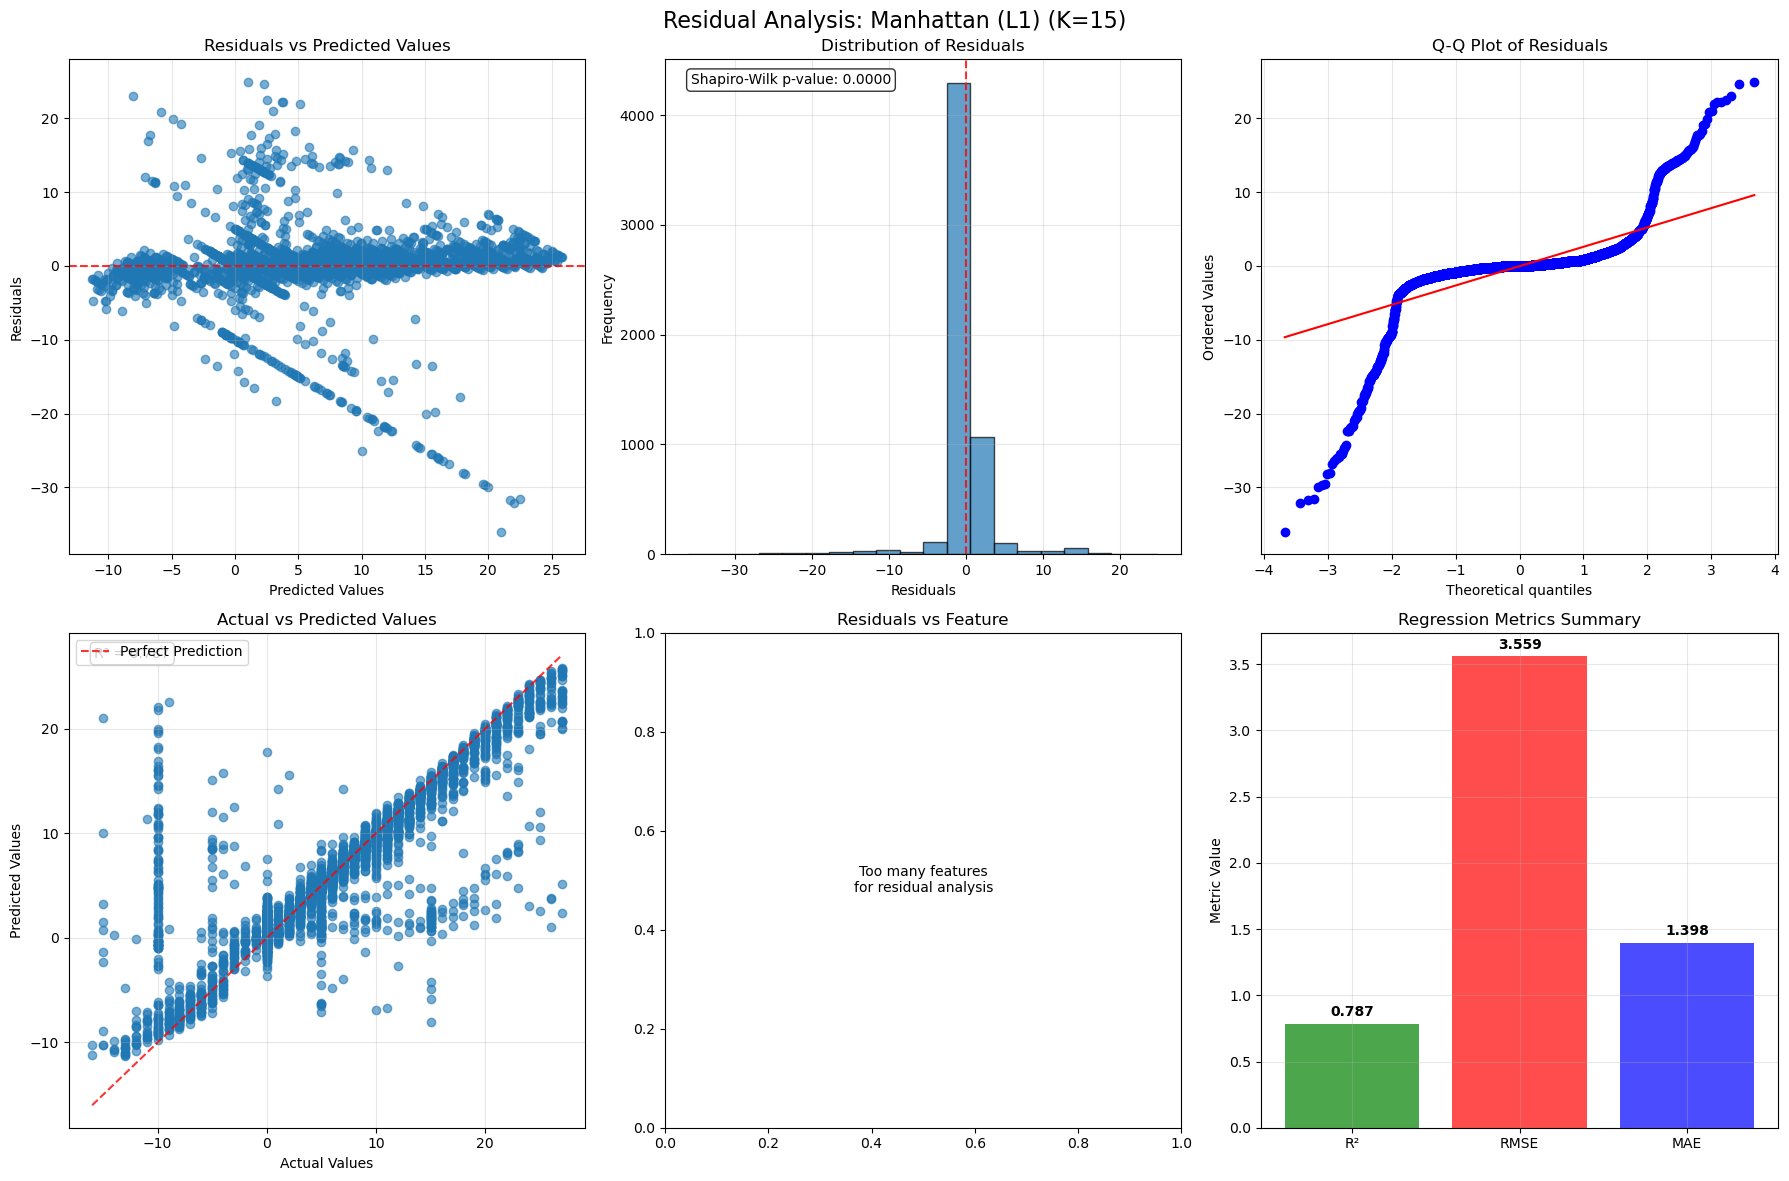


 Detailed Regression Metrics:
   R² Score: 0.7870
   Mean Squared Error: 12.6671
   Root Mean Squared Error: 3.5591
   Mean Absolute Error: 1.3984
   Mean Target Value: 5.1764
   RMSE as % of target mean: 68.76%

 STEP 8: Learning Curve Analysis...


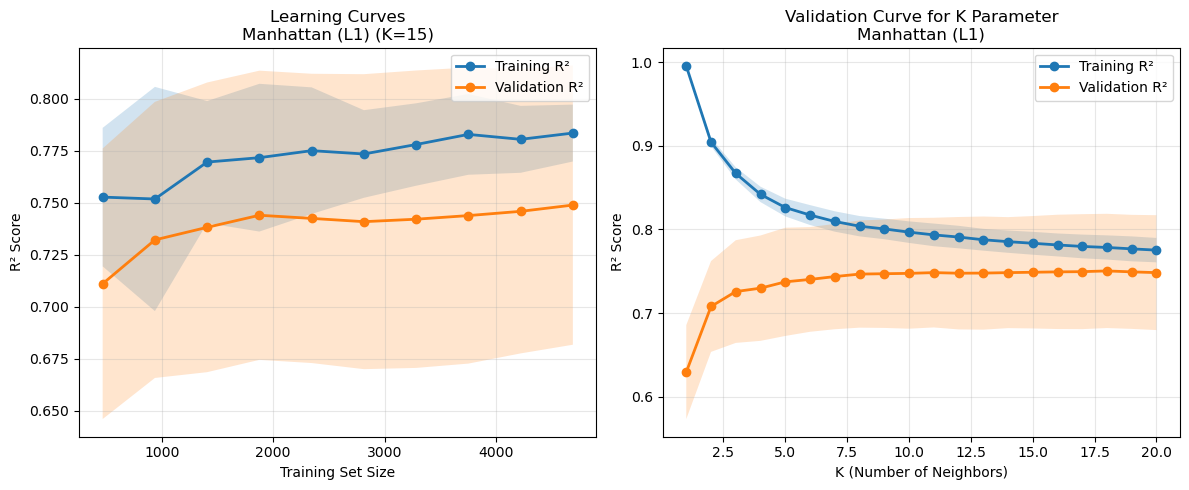


 Overfitting Analysis:
   Final Training R²: 0.784
   Final Validation R²: 0.749
   Overfitting Gap: 0.035
   Assessment: ✅ Low risk of overfitting

 COMPREHENSIVE KNN REGRESSION ANALYSIS SUMMARY

  DISTANCE METRICS RANKING (by R² Score):
   1. Manhattan (L1) (K=15): R²=0.748 ± 0.071, RMSE=3.826
   2. Manhattan (L1) (K=11): R²=0.748 ± 0.072, RMSE=3.828
   3. Manhattan (L1) (K=9): R²=0.747 ± 0.072, RMSE=3.835
   4. Euclidean (L2) (K=15): R²=0.743 ± 0.073, RMSE=3.864
   5. Manhattan (L1) (K=7): R²=0.743 ± 0.075, RMSE=3.866

  DISTANCE METRIC CHARACTERISTICS:
   Euclidean (L2):
     Best R²: 0.743
     R² Range: 0.140
     R² Stability (std): 0.047
     Best RMSE: 3.864
   Manhattan (L1):
     Best R²: 0.748
     R² Range: 0.142
     R² Stability (std): 0.048
     Best RMSE: 3.826
   Chebyshev (L_inf):
     Best R²: 0.740
     R² Range: 0.162
     R² Stability (std): 0.054
     Best RMSE: 3.894
   Minkowski (p=3):
     Best R²: 0.741
     R² Range: 0.149
     R² Stability (std): 0.051
  

In [39]:
# Extended K-Nearest Neighbors Regression Analysis and Distance Metrics Evaluation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score, KFold, learning_curve, validation_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy import stats
from scipy.stats import pearsonr

# Cell 1: Evaluate KNN Regressor Performance with different distance metrics
def evaluate_knn_distance_metrics_regression(X, y, feature_names):
    """Evaluate KNN Regressor with different distance metrics and hyperparameters"""
    print("\n KNN Regression Distance Metrics Analysis...")
    
    # Distance metrics to test
    distance_metrics = {
        'euclidean': 'Euclidean (L2)',
        'manhattan': 'Manhattan (L1)', 
        'chebyshev': 'Chebyshev (L_inf)',
        'minkowski': 'Minkowski (p=3)'
    }
    
    # K values to test
    k_values = [1, 3, 5, 7, 9, 11, 15]
    
    results = {}
    
    # Cross-validation setup (KFold for regression)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    
    print(f" Testing {len(distance_metrics)} distance metrics with K values: {k_values}")
    
    for metric_name, metric_display in distance_metrics.items():
        print(f"\n Evaluating {metric_display}...")
        
        metric_results = {}
        
        for k in k_values:
            # Handle minkowski metric with p parameter
            if metric_name == 'minkowski':
                model = KNeighborsRegressor(
                    n_neighbors=k, 
                    metric=metric_name,
                    p=3,  # p=3 for Minkowski
                    weights='uniform'
                )
            else:
                model = KNeighborsRegressor(
                    n_neighbors=k, 
                    metric=metric_name,
                    weights='uniform'
                )
            
            # Cross-validation scores for regression
            cv_scores_r2 = cross_val_score(model, X, y, cv=cv, scoring='r2')
            cv_scores_neg_mse = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
            cv_scores_rmse = np.sqrt(-cv_scores_neg_mse)
            
            metric_results[k] = {
                'mean_r2': cv_scores_r2.mean(),
                'std_r2': cv_scores_r2.std(),
                'mean_rmse': cv_scores_rmse.mean(),
                'std_rmse': cv_scores_rmse.std(),
                'model': model
            }
            
            print(f"   K={k}: R²={cv_scores_r2.mean():.3f} ± {cv_scores_r2.std():.3f}, RMSE={cv_scores_rmse.mean():.3f} ± {cv_scores_rmse.std():.3f}")
        
        results[metric_name] = {
            'display_name': metric_display,
            'results': metric_results
        }
    
    return results

# Cell 2: Visualize distance metrics comparison for regression
def plot_distance_metrics_comparison_regression(distance_results):
    """Plot comparison of different distance metrics for regression"""
    print("\n Creating distance metrics comparison plots...")
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('KNN Regression Performance Across Distance Metrics and K Values', fontsize=16)
    
    # Extract data for plotting
    k_values = list(next(iter(distance_results.values()))['results'].keys())
    
    # Plot 1: R² scores line plot
    ax = axes[0, 0]
    for metric_name, metric_data in distance_results.items():
        r2_means = [metric_data['results'][k]['mean_r2'] for k in k_values]
        r2_stds = [metric_data['results'][k]['std_r2'] for k in k_values]
        
        ax.plot(k_values, r2_means, 'o-', label=metric_data['display_name'], linewidth=2, markersize=6)
        ax.fill_between(k_values, 
                        [m - s for m, s in zip(r2_means, r2_stds)], 
                        [m + s for m, s in zip(r2_means, r2_stds)], 
                        alpha=0.2)
    
    ax.set_xlabel('K (Number of Neighbors)')
    ax.set_ylabel('R² Score')
    ax.set_title('R² Score vs K Value by Distance Metric')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1.0)
    
    # Plot 2: Best R² performance for each metric
    ax = axes[0, 1]
    metric_names = []
    best_r2_scores = []
    best_k_values = []
    
    for metric_name, metric_data in distance_results.items():
        best_k = max(metric_data['results'].keys(), 
                     key=lambda k: metric_data['results'][k]['mean_r2'])
        best_r2 = metric_data['results'][best_k]['mean_r2']
        
        metric_names.append(metric_data['display_name'])
        best_r2_scores.append(best_r2)
        best_k_values.append(best_k)
    
    bars = ax.bar(metric_names, best_r2_scores, alpha=0.7, color=['skyblue', 'lightgreen', 'coral', 'gold'])
    ax.set_ylabel('Best R² Score')
    ax.set_title('Best R² Performance by Distance Metric')
    ax.set_ylim(0, 1.0)
    
    # Add best K values on bars
    for bar, k_val in zip(bars, best_k_values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'K={k_val}', ha='center', va='bottom', fontweight='bold')
    
    ax.grid(True, alpha=0.3)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    # Plot 3: RMSE comparison
    ax = axes[1, 0]
    for metric_name, metric_data in distance_results.items():
        rmse_means = [metric_data['results'][k]['mean_rmse'] for k in k_values]
        rmse_stds = [metric_data['results'][k]['std_rmse'] for k in k_values]
        
        ax.plot(k_values, rmse_means, 'o-', label=metric_data['display_name'], linewidth=2, markersize=6)
        ax.fill_between(k_values, 
                        [m - s for m, s in zip(rmse_means, rmse_stds)], 
                        [m + s for m, s in zip(rmse_means, rmse_stds)], 
                        alpha=0.2)
    
    ax.set_xlabel('K (Number of Neighbors)')
    ax.set_ylabel('RMSE')
    ax.set_title('RMSE vs K Value by Distance Metric')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 4: R² Heatmap
    ax = axes[1, 1]
    
    # Create heatmap data
    heatmap_data = []
    metric_labels = []
    
    for metric_name, metric_data in distance_results.items():
        r2_scores = [metric_data['results'][k]['mean_r2'] for k in k_values]
        heatmap_data.append(r2_scores)
        metric_labels.append(metric_data['display_name'])
    
    heatmap_data = np.array(heatmap_data)
    
    im = ax.imshow(heatmap_data, cmap='RdYlBu_r', aspect='auto')
    ax.set_xticks(range(len(k_values)))
    ax.set_xticklabels(k_values)
    ax.set_yticks(range(len(metric_labels)))
    ax.set_yticklabels(metric_labels)
    ax.set_xlabel('K Value')
    ax.set_ylabel('Distance Metric')
    ax.set_title('R² Score Heatmap')
    
    # Add text annotations
    for i in range(len(metric_labels)):
        for j in range(len(k_values)):
            text = ax.text(j, i, f'{heatmap_data[i, j]:.3f}',
                          ha="center", va="center", color="black", fontsize=8)
    
    plt.colorbar(im, ax=ax, label='R² Score')
    
    plt.tight_layout()
    plt.show()

# Cell 3: Detailed residual analysis for best KNN regression model
def perform_residual_analysis_regression(X, y, distance_results, feature_names):
    """Perform residual analysis for the best KNN regression model"""
    print("\n STEP 7: Residual Analysis for Best KNN Regression Model...")
    
    # Find best model (highest R²)
    best_metric = None
    best_k = None
    best_r2 = -np.inf
    
    for metric_name, metric_data in distance_results.items():
        for k, results in metric_data['results'].items():
            if results['mean_r2'] > best_r2:
                best_r2 = results['mean_r2']
                best_metric = metric_name
                best_k = k
    
    print(f" Best model: {distance_results[best_metric]['display_name']} with K={best_k}")
    print(f" Best cross-validation R² score: {best_r2:.3f}")
    
    # Get the best model
    best_model = distance_results[best_metric]['results'][best_k]['model']
    
    # Fit on full dataset for analysis
    best_model.fit(X, y)
    y_pred = best_model.predict(X)
    
    # Calculate residuals - ensure proper shape
    residuals = np.array(y).flatten() - np.array(y_pred).flatten()
    
    # Create residual analysis plots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'Residual Analysis: {distance_results[best_metric]["display_name"]} (K={best_k})', fontsize=16)
    
    # Plot 1: Residuals vs Predicted Values
    ax = axes[0, 0]
    ax.scatter(y_pred, residuals, alpha=0.6)
    ax.axhline(y=0, color='red', linestyle='--', alpha=0.8)
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Residuals')
    ax.set_title('Residuals vs Predicted Values')
    ax.grid(True, alpha=0.3)
    
    # Plot 2: Histogram of residuals
    ax = axes[0, 1]
    ax.hist(residuals, bins=20, alpha=0.7, edgecolor='black')
    ax.axvline(x=0, color='red', linestyle='--', alpha=0.8)
    ax.set_xlabel('Residuals')
    ax.set_ylabel('Frequency')
    ax.set_title('Distribution of Residuals')
    ax.grid(True, alpha=0.3)
    
    # Add normality test
    residuals_sample = residuals.flatten()[:min(5000, len(residuals))]  # Ensure 1D array
    _, p_value = stats.shapiro(residuals_sample)
    ax.text(0.05, 0.95, f'Shapiro-Wilk p-value: {p_value:.4f}', 
           transform=ax.transAxes, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Plot 3: Q-Q plot of residuals
    ax = axes[0, 2]
    stats.probplot(residuals.flatten(), dist="norm", plot=ax)
    ax.set_title('Q-Q Plot of Residuals')
    ax.grid(True, alpha=0.3)
    
    # Plot 4: Actual vs Predicted
    ax = axes[1, 0]
    ax.scatter(y, y_pred, alpha=0.6)
    
    # Perfect prediction line
    min_val = min(float(y.min()), float(y_pred.min()))
    max_val = max(float(y.max()), float(y_pred.max()))
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, label='Perfect Prediction')
    
    ax.set_xlabel('Actual Values')
    ax.set_ylabel('Predicted Values')
    ax.set_title('Actual vs Predicted Values')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Add R² score
    r2 = r2_score(y, y_pred)
    ax.text(0.05, 0.95, f'R² = {r2:.3f}', transform=ax.transAxes, 
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Plot 5: Residuals vs Features (if manageable number)
    ax = axes[1, 1]
    if len(feature_names) <= 8:
        # Show residuals vs most important feature (highest correlation with target)
        try:
            correlations = []
            for feature in feature_names:
                if feature in X.columns:
                    temp_df = pd.DataFrame({'feature': X[feature], 'target': y}).dropna()
                    if len(temp_df) > 1 and temp_df['feature'].std() > 0:
                        corr, _ = pearsonr(temp_df['feature'], temp_df['target'])
                        correlations.append((feature, abs(corr)))
            
            if correlations:
                best_feature = max(correlations, key=lambda x: x[1])[0]
                ax.scatter(X[best_feature], residuals, alpha=0.6)
                ax.axhline(y=0, color='red', linestyle='--', alpha=0.8)
                ax.set_xlabel(f'{best_feature}')
                ax.set_ylabel('Residuals')
                ax.set_title(f'Residuals vs {best_feature}')
                ax.grid(True, alpha=0.3)
            else:
                ax.text(0.5, 0.5, 'Feature correlation\nanalysis failed', 
                       ha='center', va='center', transform=ax.transAxes)
                ax.set_title('Residuals vs Feature')
        except:
            ax.text(0.5, 0.5, 'Feature analysis\nnot available', 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title('Residuals vs Feature')
    else:
        ax.text(0.5, 0.5, 'Too many features\nfor residual analysis', 
               ha='center', va='center', transform=ax.transAxes)
        ax.set_title('Residuals vs Feature')
    
    # Plot 6: Error metrics summary
    ax = axes[1, 2]
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, y_pred)
    
    metrics = ['R²', 'RMSE', 'MAE']
    values = [r2, rmse, mae]
    colors = ['green' if r2 > 0.5 else 'orange', 'red', 'blue']
    
    bars = ax.bar(metrics, values, color=colors, alpha=0.7)
    ax.set_ylabel('Metric Value')
    ax.set_title('Regression Metrics Summary')
    ax.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(values)*0.01,
               f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed metrics
    print(f"\n Detailed Regression Metrics:")
    print(f"   R² Score: {r2:.4f}")
    print(f"   Mean Squared Error: {mse:.4f}")
    print(f"   Root Mean Squared Error: {rmse:.4f}")
    print(f"   Mean Absolute Error: {mae:.4f}")
    print(f"   Mean Target Value: {float(y.mean()):.4f}")
    print(f"   RMSE as % of target mean: {(rmse/float(y.mean()))*100:.2f}%")
    
    return {
        'best_model': best_model,
        'best_metric': best_metric,
        'best_k': best_k,
        'best_r2': best_r2,
        'residuals': residuals,
        'predictions': y_pred,
        'r2_score': r2,
        'rmse': rmse,
        'mae': mae
    }

# Cell 4: Learning curves for regression
def plot_learning_curves_regression(X, y, distance_results):
    """Plot learning curves to assess overfitting for regression"""
    print("\n STEP 8: Learning Curve Analysis...")
    
    # Get best model configuration
    best_metric = None
    best_k = None
    best_r2 = -np.inf
    
    for metric_name, metric_data in distance_results.items():
        for k, results in metric_data['results'].items():
            if results['mean_r2'] > best_r2:
                best_r2 = results['mean_r2']
                best_metric = metric_name
                best_k = k
    
    best_model = distance_results[best_metric]['results'][best_k]['model']
    
    # Generate learning curves
    train_sizes = np.linspace(0.1, 1.0, 10)
    train_sizes_abs, train_scores, val_scores = learning_curve(
        best_model, X, y, 
        train_sizes=train_sizes,
        cv=5, 
        scoring='r2',
        random_state=42
    )
    
    # Plot learning curves
    plt.figure(figsize=(12, 5))
    
    # Learning curve
    plt.subplot(1, 2, 1)
    plt.plot(train_sizes_abs, np.mean(train_scores, axis=1), 'o-', 
             label='Training R²', linewidth=2, markersize=6)
    plt.fill_between(train_sizes_abs, 
                     np.mean(train_scores, axis=1) - np.std(train_scores, axis=1),
                     np.mean(train_scores, axis=1) + np.std(train_scores, axis=1),
                     alpha=0.2)
    
    plt.plot(train_sizes_abs, np.mean(val_scores, axis=1), 'o-', 
             label='Validation R²', linewidth=2, markersize=6)
    plt.fill_between(train_sizes_abs, 
                     np.mean(val_scores, axis=1) - np.std(val_scores, axis=1),
                     np.mean(val_scores, axis=1) + np.std(val_scores, axis=1),
                     alpha=0.2)
    
    plt.xlabel('Training Set Size')
    plt.ylabel('R² Score')
    plt.title(f'Learning Curves\n{distance_results[best_metric]["display_name"]} (K={best_k})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Validation curve for K parameter
    plt.subplot(1, 2, 2)
    k_range = range(1, min(21, len(X)//2))  # Don't exceed reasonable K values
    
    if best_metric == 'minkowski':
        model_for_validation = KNeighborsRegressor(metric=best_metric, p=3)
    else:
        model_for_validation = KNeighborsRegressor(metric=best_metric)
    
    train_scores_k, val_scores_k = validation_curve(
        model_for_validation, X, y,
        param_name='n_neighbors', param_range=k_range,
        cv=5, scoring='r2'
    )
    
    plt.plot(k_range, np.mean(train_scores_k, axis=1), 'o-', 
             label='Training R²', linewidth=2, markersize=6)
    plt.fill_between(k_range, 
                     np.mean(train_scores_k, axis=1) - np.std(train_scores_k, axis=1),
                     np.mean(train_scores_k, axis=1) + np.std(train_scores_k, axis=1),
                     alpha=0.2)
    
    plt.plot(k_range, np.mean(val_scores_k, axis=1), 'o-', 
             label='Validation R²', linewidth=2, markersize=6)
    plt.fill_between(k_range, 
                     np.mean(val_scores_k, axis=1) - np.std(val_scores_k, axis=1),
                     np.mean(val_scores_k, axis=1) + np.std(val_scores_k, axis=1),
                     alpha=0.2)
    
    plt.xlabel('K (Number of Neighbors)')
    plt.ylabel('R² Score')
    plt.title(f'Validation Curve for K Parameter\n{distance_results[best_metric]["display_name"]}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Analyze overfitting
    final_train_score = np.mean(train_scores[-1])
    final_val_score = np.mean(val_scores[-1])
    overfitting_gap = final_train_score - final_val_score
    
    print(f"\n Overfitting Analysis:")
    print(f"   Final Training R²: {final_train_score:.3f}")
    print(f"   Final Validation R²: {final_val_score:.3f}")
    print(f"   Overfitting Gap: {overfitting_gap:.3f}")
    
    if overfitting_gap < 0.05:
        print("   Assessment: ✅ Low risk of overfitting")
    elif overfitting_gap < 0.15:
        print("   Assessment: ⚠️ Moderate risk of overfitting")
    else:
        print("   Assessment: ❌ High risk of overfitting")

# Cell 5: Summary of distance metrics and KNN regression analysis
def summarize_knn_regression_analysis(distance_results, residual_analysis):
    """Provide comprehensive summary of KNN regression analysis"""
    print("\n" + "="*80)
    print(" COMPREHENSIVE KNN REGRESSION ANALYSIS SUMMARY")
    print("="*80)
    
    # Find best performing metric and K
    best_results = []
    for metric_name, metric_data in distance_results.items():
        for k, results in metric_data['results'].items():
            best_results.append({
                'metric': metric_data['display_name'],
                'k': k,
                'r2': results['mean_r2'],
                'rmse': results['mean_rmse'],
                'r2_std': results['std_r2']
            })
    
    best_results.sort(key=lambda x: x['r2'], reverse=True)
    
    print(f"\n  DISTANCE METRICS RANKING (by R² Score):")
    for i, result in enumerate(best_results[:5]):  # Top 5
        print(f"   {i+1}. {result['metric']} (K={result['k']}): "
              f"R²={result['r2']:.3f} ± {result['r2_std']:.3f}, RMSE={result['rmse']:.3f}")
    
    # Calculate metric-specific insights
    metric_performance = {}
    for metric_name, metric_data in distance_results.items():
        r2_scores = [results['mean_r2'] for results in metric_data['results'].values()]
        rmse_scores = [results['mean_rmse'] for results in metric_data['results'].values()]
        metric_performance[metric_data['display_name']] = {
            'best_r2': max(r2_scores),
            'worst_r2': min(r2_scores),
            'r2_range': max(r2_scores) - min(r2_scores),
            'r2_stability': np.std(r2_scores),
            'best_rmse': min(rmse_scores),
            'worst_rmse': max(rmse_scores)
        }
    
    print(f"\n  DISTANCE METRIC CHARACTERISTICS:")
    for metric, stats in metric_performance.items():
        print(f"   {metric}:")
        print(f"     Best R²: {stats['best_r2']:.3f}")
        print(f"     R² Range: {stats['r2_range']:.3f}")
        print(f"     R² Stability (std): {stats['r2_stability']:.3f}")
        print(f"     Best RMSE: {stats['best_rmse']:.3f}")
    
    # Key insights
    print(f"\n 🔍 KEY INSIGHTS:")
    
    # Most stable metric
    most_stable = min(metric_performance.keys(), 
                     key=lambda x: metric_performance[x]['r2_stability'])
    print(f"   • Most Stable Metric: {most_stable}")
    
    # Best overall metric
    best_overall = max(metric_performance.keys(), 
                      key=lambda x: metric_performance[x]['best_r2'])
    print(f"   • Best Overall Performance: {best_overall}")
    
    # K value analysis
    k_counts = {}
    for result in best_results:
        k = result['k']
        k_counts[k] = k_counts.get(k, 0) + 1
    
    most_common_k = max(k_counts.keys(), key=lambda x: k_counts[x])
    print(f"   • Most Successful K Value: {most_common_k} (appeared in {k_counts[most_common_k]} top configurations)")
    
    # Dataset-specific recommendations
    print(f"\n 💡 RECOMMENDATIONS FOR THIS REGRESSION DATASET:")
    print(f"   • With {len(residual_analysis['predictions'])} samples:")
    
    if residual_analysis['r2_score'] > 0.7:
        print(f"     - ✅ Excellent model performance (R² = {residual_analysis['r2_score']:.3f})")
    elif residual_analysis['r2_score'] > 0.5:
        print(f"     - ⚠️ Good model performance (R² = {residual_analysis['r2_score']:.3f})")
    else:
        print(f"     - ❌ Poor model performance (R² = {residual_analysis['r2_score']:.3f})")
        print(f"     - Consider feature engineering or different algorithms")
    
    print(f"     - Best distance metric: {residual_analysis['best_metric'].title()}")
    print(f"     - Optimal K value: {residual_analysis['best_k']}")
    print(f"     - Expected RMSE: {residual_analysis['rmse']:.3f}")
    print(f"     - Expected MAE: {residual_analysis['mae']:.3f}")
    
    # Usage example
    print(f"\n 🚀 USAGE EXAMPLE:")
    print(f"   ```python")
    print(f"   # Best configuration for your dataset:")
    if residual_analysis['best_metric'] == 'minkowski':
        print(f"   best_model = KNeighborsRegressor(")
        print(f"       n_neighbors={residual_analysis['best_k']},")
        print(f"       metric='{residual_analysis['best_metric']}',")
        print(f"       p=3,")
        print(f"       weights='uniform'")
        print(f"   )")
    else:
        print(f"   best_model = KNeighborsRegressor(")
        print(f"       n_neighbors={residual_analysis['best_k']},")
        print(f"       metric='{residual_analysis['best_metric']}',")
        print(f"       weights='uniform'")
        print(f"   )")
    print(f"   ```")

# Usage examples:
# Run the complete analysis:
distance_results = evaluate_knn_distance_metrics_regression(X_selected, y_train, feature_names)
plot_distance_metrics_comparison_regression(distance_results)
residual_analysis = perform_residual_analysis_regression(X_selected, y_train, distance_results, feature_names)
plot_learning_curves_regression(X_selected, y_train, distance_results)
summarize_knn_regression_analysis(distance_results, residual_analysis)